In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_20_11_47
NN-MODEL FILENAME:  ./models/VBKG0BIX_20_11_47_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 5e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 20000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1284.00 MiB, increment: 1064.15 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


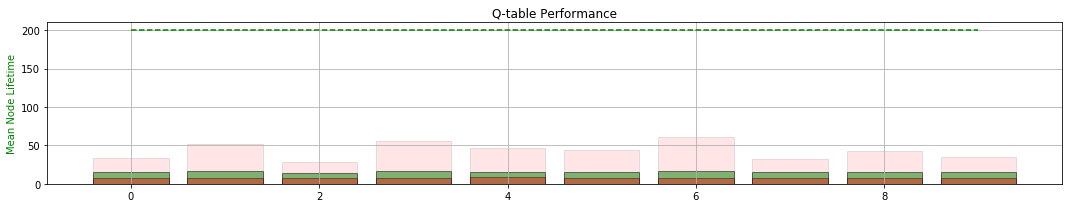

MEMORY COUNTER:  15558
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 588.018	LOSS : 526.345	LOSS : 531.804	LOSS : 493.477	LOSS : 517.723	LOSS : 491.674	LOSS : 508.057	LOSS : 484.921	
Validating... MEAN TIME:  9.36
LOSS : 478.739	LOSS : 483.014	LOSS : 499.496	LOSS : 483.518	LOSS : 485.129	LOSS : 475.777	LOSS : 467.616	LOSS : 451.015	
Validating... MEAN TIME:  134.38
LOSS : 453.301	LOSS : 457.246	LOSS : 431.671	LOSS : 444.233	LOSS : 435.184	LOSS : 439.839	LOSS : 430.165	LOSS : 423.546	
Validating... MEAN TIME:  86.31
LOSS : 427.358	LOSS : 433.864	LOSS : 422.032	LOSS : 432.461	LOSS : 417.607	LOSS : 417.730	LOSS : 418.850	LOSS : 410.137	
Validating... MEAN TIME:  82.75
LOSS : 409.594	LOSS : 426.719	LOSS : 409.406	LOSS : 407.388	LOSS : 414.771	LOSS : 401.814	LOSS : 417.148	LOSS : 395.667	
Validating... MEAN TIME:  111.345
TRAINING TIME:0:00:46.152547


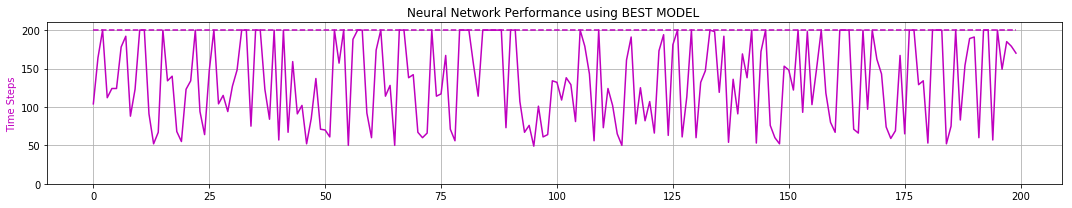

peak memory: 1322.39 MiB, increment: 1045.22 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   55306
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 144
TOTAL SERIAL TIMESTEPS:   70864
TOTAL PARALLEL TIME

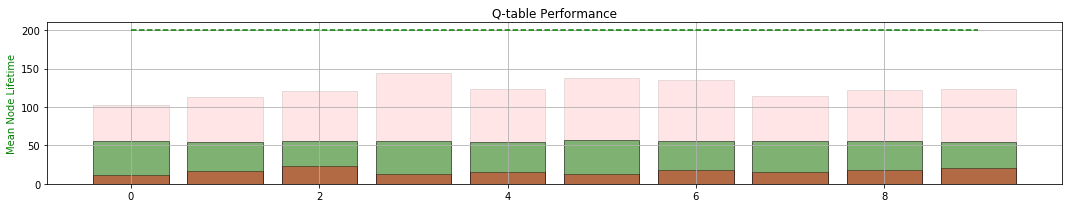

MEMORY COUNTER:  70864
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 241.996	LOSS : 225.283	LOSS : 234.463	LOSS : 221.755	LOSS : 221.628	LOSS : 231.834	LOSS : 238.499	LOSS : 230.960	
Validating... MEAN TIME:  150.185
LOSS : 230.364	LOSS : 250.322	LOSS : 216.895	LOSS : 225.675	LOSS : 214.182	LOSS : 209.427	LOSS : 237.572	LOSS : 230.406	
Validating... MEAN TIME:  168.51
LOSS : 217.099	LOSS : 217.997	LOSS : 224.947	LOSS : 213.780	LOSS : 220.783	LOSS : 222.369	LOSS : 204.699	LOSS : 211.962	
Validating... MEAN TIME:  181.58
LOSS : 204.769	LOSS : 214.242	LOSS : 222.915	LOSS : 219.751	LOSS : 199.675	LOSS : 213.586	LOSS : 201.678	LOSS : 224.619	
Validating... MEAN TIME:  190.45
LOSS : 216.161	LOSS : 217.636	LOSS : 216.225	LOSS : 214.304	LOSS : 227.543	LOSS : 241.272	LOSS : 212.890	LOSS : 208.425	
Validating... MEAN TIME:  193.23
TRAINING TIME:0:01:00.647467


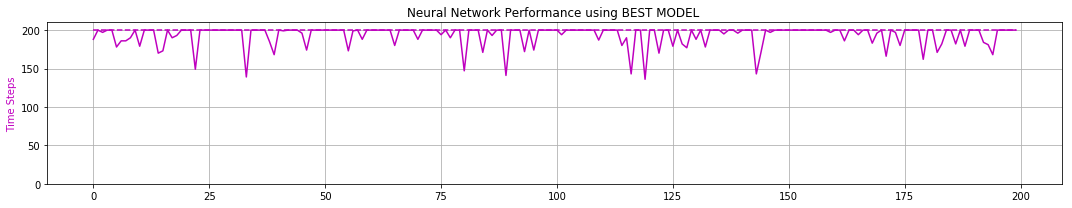

peak memory: 1369.80 MiB, increment: 1029.98 MiB
0 -max- [ 0.480  1.647  0.209  2.066]
0 -min- [-0.550 -1.415 -0.207 -1.574]

1 -max- [ 0.320  0.970  0.209  1.872]
1 -min- [-0.637 -1.268 -0.209 -1.601]

2 -max- [ 0.235  1.129  0.209  1.865]
2 -min- [-0.571 -1.126 -0.209 -1.438]

3 -max- [ 0.232  1.086  0.209  1.736]
3 -min- [-0.574 -1.329 -0.209 -1.439]

4 -max- [ 0.296  1.285  0.209  1.854]
4 -min- [-0.377 -1.292 -0.209 -1.705]

5 -max- [ 0.224  1.491  0.209  1.885]
5 -min- [-0.503 -1.284 -0.209 -1.636]

6 -max- [ 0.317  1.152  0.209  1.754]
6 -min- [-0.461 -1.518 -0.209 -1.704]

7 -max- [ 0.243  1.036  0.209  1.536]
7 -min- [-0.492 -1.103 -0.209 -1.849]

8 -max- [ 0.366  1.352  0.209  1.689]
8 -min- [-0.379 -1.339 -0.209 -2.050]

9 -max- [ 0.434  1.468  0.209  1.713]
9 -min- [-0.697 -1.307 -0.209 -1.608]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   142738
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   213602
TOTAL PARALLEL TI

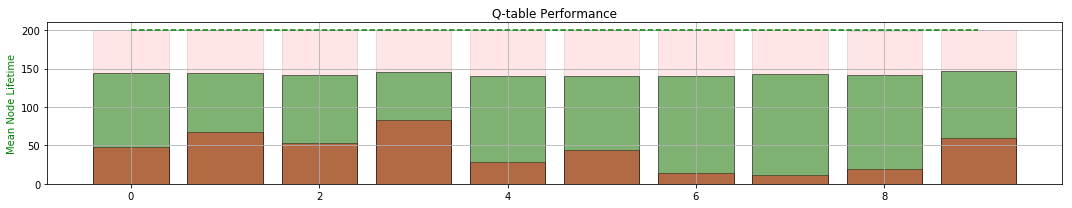

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 103.395	LOSS : 107.195	LOSS : 107.384	LOSS : 99.959	LOSS : 94.332	LOSS : 96.521	LOSS : 109.724	LOSS : 105.431	
Validating... MEAN TIME:  160.795
LOSS : 102.704	LOSS : 103.963	LOSS : 105.830	LOSS : 94.132	LOSS : 114.040	LOSS : 94.950	LOSS : 110.633	LOSS : 106.439	
Validating... MEAN TIME:  158.375
LOSS : 98.513	LOSS : 89.252	LOSS : 117.012	LOSS : 98.862	LOSS : 100.484	LOSS : 103.906	LOSS : 98.768	LOSS : 95.038	
Validating... MEAN TIME:  157.095
LOSS : 104.200	LOSS : 89.122	LOSS : 105.198	LOSS : 91.637	LOSS : 110.917	LOSS : 93.135	LOSS : 103.955	LOSS : 99.597	
Validating... MEAN TIME:  160.84
LOSS : 111.817	LOSS : 106.720	LOSS : 94.745	LOSS : 94.887	LOSS : 97.889	LOSS : 106.112	LOSS : 94.953	LOSS : 94.182	
Validating... MEAN TIME:  157.9
TRAINING TIME:0:00:59.914926


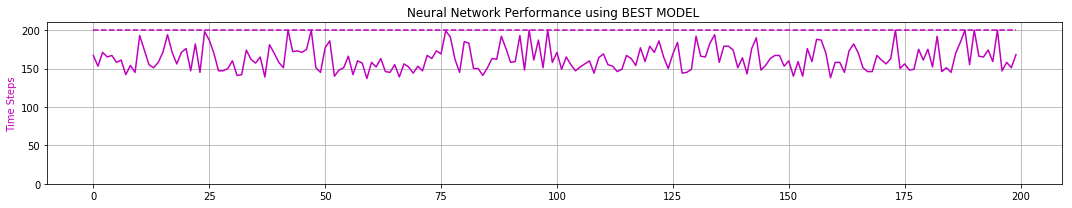

peak memory: 1435.91 MiB, increment: 1072.56 MiB
0 -max- [ 0.128  0.822  0.119  1.286]
0 -min- [-2.400 -2.743 -0.208 -1.401]

1 -max- [ 0.135  0.828  0.050  1.121]
1 -min- [-2.400 -2.797 -0.208 -1.340]

2 -max- [ 0.192  0.754  0.047  1.201]
2 -min- [-2.400 -2.964 -0.209 -1.589]

3 -max- [ 0.166  0.804  0.070  1.185]
3 -min- [-2.400 -2.753 -0.208 -1.673]

4 -max- [ 0.132  0.959  0.066  1.234]
4 -min- [-2.400 -2.786 -0.209 -1.634]

5 -max- [ 0.166  0.814  0.106  1.181]
5 -min- [-2.400 -2.764 -0.209 -1.615]

6 -max- [ 0.788  1.150  0.172  1.314]
6 -min- [-2.399 -2.917 -0.207 -1.546]

7 -max- [ 0.148  0.955  0.071  1.171]
7 -min- [-2.400 -2.798 -0.207 -1.703]

8 -max- [ 0.130  0.790  0.075  1.165]
8 -min- [-2.399 -2.761 -0.209 -1.409]

9 -max- [ 0.180  0.805  0.055  1.171]
9 -min- [-2.400 -2.788 -0.209 -1.661]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   131666
SMALLEST TIMESTEP: 112
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   345268
TOTAL PARALLEL T

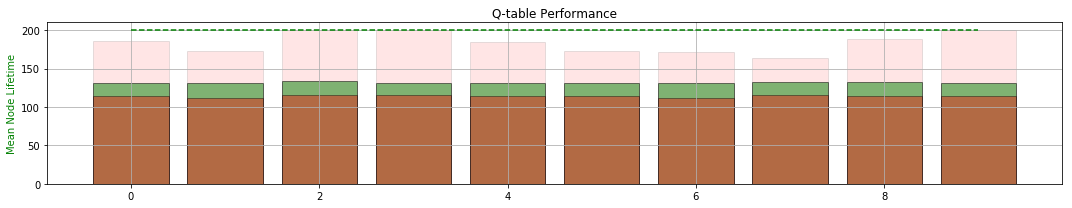

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 76.897	LOSS : 75.938	LOSS : 73.149	LOSS : 71.244	LOSS : 79.829	LOSS : 61.596	LOSS : 72.573	LOSS : 69.216	
Validating... MEAN TIME:  142.285
LOSS : 70.283	LOSS : 77.253	LOSS : 66.464	LOSS : 66.101	LOSS : 67.737	LOSS : 69.001	LOSS : 62.801	LOSS : 71.070	
Validating... MEAN TIME:  138.245
LOSS : 59.688	LOSS : 64.140	LOSS : 63.811	LOSS : 59.915	LOSS : 76.744	LOSS : 74.316	LOSS : 67.226	LOSS : 71.750	
Validating... MEAN TIME:  136.625
LOSS : 66.433	LOSS : 71.196	LOSS : 68.028	LOSS : 57.465	LOSS : 63.118	LOSS : 66.590	LOSS : 64.419	LOSS : 68.960	
Validating... MEAN TIME:  136.75
LOSS : 69.189	LOSS : 59.460	LOSS : 68.009	LOSS : 60.180	LOSS : 64.915	LOSS : 64.336	LOSS : 67.785	LOSS : 74.381	
Validating... MEAN TIME:  145.145
TRAINING TIME:0:00:54.143691


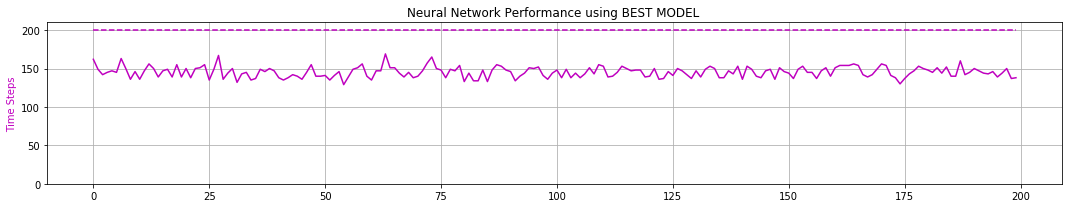

peak memory: 1401.69 MiB, increment: 994.28 MiB
0 -max- [ 0.141  0.601  0.050  0.848]
0 -min- [-2.399 -2.919 -0.209 -1.123]

1 -max- [ 0.138  0.590  0.050  0.871]
1 -min- [-2.400 -2.931 -0.208 -1.102]

2 -max- [ 0.194  0.562  0.048  0.863]
2 -min- [-2.400 -2.795 -0.204 -1.048]

3 -max- [ 0.384  0.439  0.075  0.763]
3 -min- [-2.399 -2.906 -0.182 -0.846]

4 -max- [ 0.170  0.631  0.046  0.898]
4 -min- [-2.399 -2.919 -0.201 -1.067]

5 -max- [ 0.139  0.582  0.048  0.772]
5 -min- [-2.400 -2.898 -0.202 -0.920]

6 -max- [ 0.134  0.564  0.049  0.925]
6 -min- [-2.400 -2.794 -0.208 -1.124]

7 -max- [ 0.121  0.568  0.049  0.842]
7 -min- [-2.399 -2.941 -0.184 -1.045]

8 -max- [ 0.171  0.571  0.049  0.738]
8 -min- [-2.400 -2.911 -0.191 -0.840]

9 -max- [ 0.161  0.556  0.050  0.876]
9 -min- [-2.400 -2.907 -0.204 -1.117]

Quantization TIME:  0.01 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   124329
SMALLEST TIMESTEP: 111
LARGEST  TIMESTEP: 174
TOTAL SERIAL TIMESTEPS:   469597
TOTAL PARALLEL TI

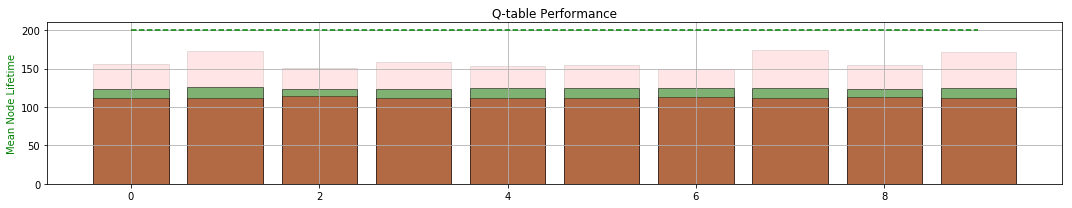

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 69.253	LOSS : 70.422	LOSS : 77.362	LOSS : 75.595	LOSS : 73.299	LOSS : 64.965	LOSS : 66.703	LOSS : 70.448	
Validating... MEAN TIME:  127.165
LOSS : 72.215	LOSS : 75.269	LOSS : 69.767	LOSS : 66.372	LOSS : 72.706	LOSS : 65.536	LOSS : 72.512	LOSS : 66.416	
Validating... MEAN TIME:  124.56
LOSS : 63.480	LOSS : 69.352	LOSS : 69.801	LOSS : 72.728	LOSS : 73.877	LOSS : 79.333	LOSS : 70.702	LOSS : 62.718	
Validating... MEAN TIME:  126.155
LOSS : 63.961	LOSS : 70.354	LOSS : 69.639	LOSS : 69.087	LOSS : 79.124	LOSS : 71.557	LOSS : 70.352	LOSS : 66.981	
Validating... MEAN TIME:  128.21
LOSS : 65.228	LOSS : 74.538	LOSS : 71.018	LOSS : 72.603	LOSS : 69.756	LOSS : 76.138	LOSS : 63.842	LOSS : 76.809	
Validating... MEAN TIME:  130.9
TRAINING TIME:0:00:51.491511


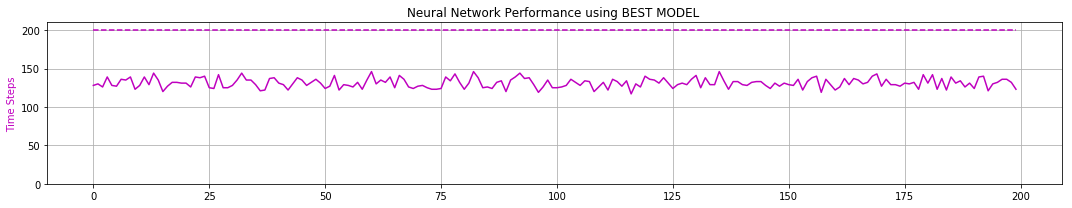

peak memory: 1454.46 MiB, increment: 978.89 MiB
0 -max- [ 0.141  0.630  0.047  0.882]
0 -min- [-2.400 -2.438 -0.146 -0.905]

1 -max- [ 0.182  0.755  0.048  0.982]
1 -min- [-2.400 -2.614 -0.160 -1.173]

2 -max- [ 0.140  0.625  0.048  0.923]
2 -min- [-2.400 -2.539 -0.159 -0.948]

3 -max- [ 0.154  0.631  0.046  0.930]
3 -min- [-2.400 -2.571 -0.168 -1.018]

4 -max- [ 0.141  0.625  0.048  0.822]
4 -min- [-2.400 -2.438 -0.154 -0.934]

5 -max- [ 0.135  0.630  0.049  0.929]
5 -min- [-2.400 -2.590 -0.168 -0.942]

6 -max- [ 0.124  0.758  0.049  0.958]
6 -min- [-2.400 -2.593 -0.151 -1.150]

7 -max- [ 0.183  0.615  0.049  0.937]
7 -min- [-2.400 -2.750 -0.150 -0.906]

8 -max- [ 0.146  0.632  0.050  0.850]
8 -min- [-2.400 -2.439 -0.174 -0.972]

9 -max- [ 0.195  0.634  0.048  0.712]
9 -min- [-2.399 -2.443 -0.166 -0.890]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   113680
SMALLEST TIMESTEP: 103
LARGEST  TIMESTEP: 134
TOTAL SERIAL TIMESTEPS:   583277
TOTAL PARALLEL TI

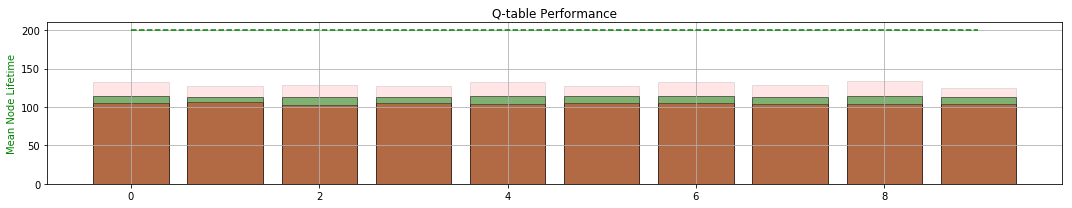

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 74.127	LOSS : 81.286	LOSS : 70.612	LOSS : 74.350	LOSS : 78.328	LOSS : 76.585	LOSS : 68.720	LOSS : 70.012	
Validating... MEAN TIME:  119.445
LOSS : 87.581	LOSS : 66.748	LOSS : 84.438	LOSS : 74.975	LOSS : 74.435	LOSS : 83.028	LOSS : 74.485	LOSS : 79.838	
Validating... MEAN TIME:  121.425
LOSS : 75.082	LOSS : 84.098	LOSS : 71.821	LOSS : 57.005	LOSS : 73.819	LOSS : 72.207	LOSS : 62.695	LOSS : 68.569	
Validating... MEAN TIME:  119.34
LOSS : 79.862	LOSS : 73.720	LOSS : 72.622	LOSS : 74.411	LOSS : 61.412	LOSS : 82.283	LOSS : 84.695	LOSS : 74.989	
Validating... MEAN TIME:  122.23
LOSS : 85.640	LOSS : 68.910	LOSS : 89.943	LOSS : 74.241	LOSS : 68.963	LOSS : 76.496	LOSS : 70.382	LOSS : 78.671	
Validating... MEAN TIME:  118.975
TRAINING TIME:0:00:49.725818


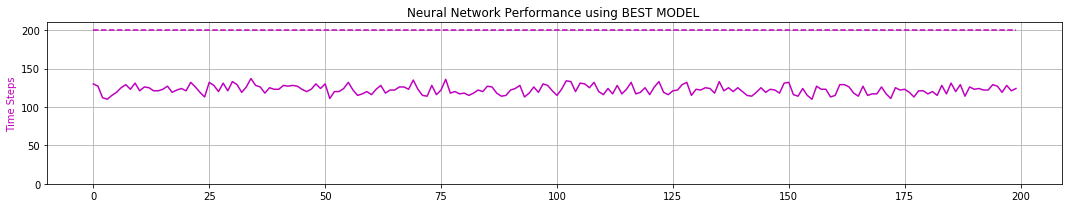

peak memory: 1452.50 MiB, increment: 1017.83 MiB
0 -max- [ 0.175  0.809  0.055  0.983]
0 -min- [-2.399 -2.921 -0.159 -1.119]

1 -max- [ 0.149  0.634  0.048  0.789]
1 -min- [-2.398 -2.780 -0.170 -1.005]

2 -max- [ 0.146  0.814  0.046  0.964]
2 -min- [-2.400 -2.780 -0.164 -1.150]

3 -max- [ 0.145  0.794  0.048  0.956]
3 -min- [-2.400 -2.921 -0.164 -1.133]

4 -max- [ 0.148  0.825  0.049  0.781]
4 -min- [-2.399 -2.762 -0.175 -1.203]

5 -max- [ 0.136  0.635  0.049  0.725]
5 -min- [-2.400 -2.746 -0.165 -0.986]

6 -max- [ 0.162  0.749  0.049  0.871]
6 -min- [-2.400 -2.796 -0.159 -1.199]

7 -max- [ 0.154  0.756  0.050  0.918]
7 -min- [-2.400 -2.953 -0.182 -1.232]

8 -max- [ 0.169  0.791  0.048  0.697]
8 -min- [-2.400 -2.754 -0.180 -1.145]

9 -max- [ 0.133  0.822  0.048  0.900]
9 -min- [-2.400 -2.781 -0.190 -1.150]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   110539
SMALLEST TIMESTEP: 70
LARGEST  TIMESTEP: 133
TOTAL SERIAL TIMESTEPS:   693816
TOTAL PARALLEL TI

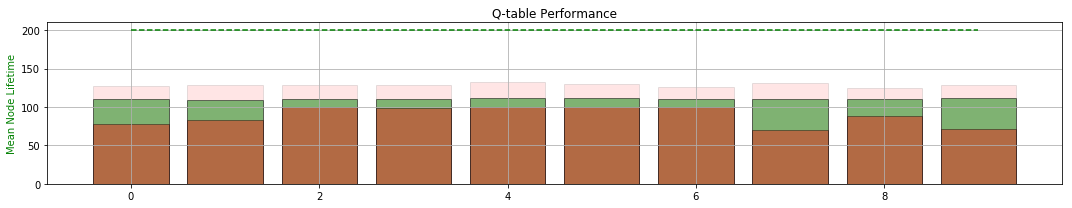

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 84.002	LOSS : 75.543	LOSS : 82.070	LOSS : 78.260	LOSS : 65.928	LOSS : 76.032	LOSS : 76.371	LOSS : 74.084	
Validating... MEAN TIME:  113.85
LOSS : 76.916	LOSS : 85.041	LOSS : 71.486	LOSS : 65.159	LOSS : 74.134	LOSS : 74.350	LOSS : 72.581	LOSS : 78.531	
Validating... MEAN TIME:  113.67
LOSS : 87.143	LOSS : 72.203	LOSS : 76.590	LOSS : 76.384	LOSS : 78.613	LOSS : 75.666	LOSS : 75.900	LOSS : 79.316	
Validating... MEAN TIME:  113.895
LOSS : 62.189	LOSS : 64.648	LOSS : 72.373	LOSS : 72.874	LOSS : 71.962	LOSS : 80.610	LOSS : 70.411	LOSS : 74.638	
Validating... MEAN TIME:  112.065
LOSS : 76.169	LOSS : 78.173	LOSS : 76.293	LOSS : 71.536	LOSS : 70.773	LOSS : 80.497	LOSS : 79.287	LOSS : 78.228	
Validating... MEAN TIME:  103.565
TRAINING TIME:0:00:48.962153


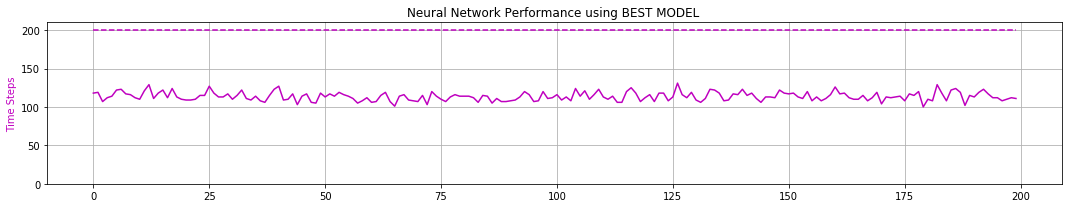

peak memory: 1455.35 MiB, increment: 1053.78 MiB
0 -max- [ 0.146  0.748  0.048  0.891]
0 -min- [-2.400 -3.166 -0.205 -1.203]

1 -max- [ 0.151  0.811  0.046  0.949]
1 -min- [-2.399 -3.152 -0.204 -1.099]

2 -max- [ 0.143  0.782  0.048  0.875]
2 -min- [-2.400 -3.084 -0.189 -1.223]

3 -max- [ 0.145  0.634  0.049  1.151]
3 -min- [-2.399 -3.173 -0.198 -1.009]

4 -max- [ 0.157  0.629  0.056  1.046]
4 -min- [-2.399 -3.169 -0.189 -0.979]

5 -max- [ 0.162  0.634  0.049  0.925]
5 -min- [-2.399 -3.154 -0.190 -0.911]

6 -max- [ 0.154  0.632  0.050  0.897]
6 -min- [-2.400 -3.169 -0.204 -1.073]

7 -max- [ 0.169  0.634  0.048  0.905]
7 -min- [-2.399 -3.159 -0.207 -0.952]

8 -max- [ 0.135  0.632  0.048  0.941]
8 -min- [-2.400 -3.181 -0.207 -1.042]

9 -max- [ 0.161  0.631  0.051  0.938]
9 -min- [-2.400 -3.178 -0.200 -1.100]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   87023
SMALLEST TIMESTEP: 26
LARGEST  TIMESTEP: 124
TOTAL SERIAL TIMESTEPS:   780839
TOTAL PARALLEL TIM

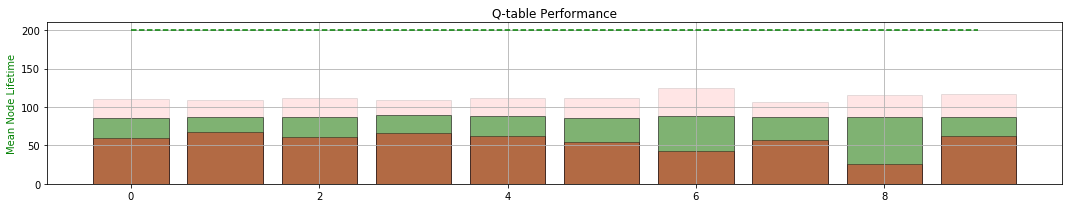

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 93.420	LOSS : 86.706	LOSS : 80.564	LOSS : 83.629	LOSS : 87.777	LOSS : 80.089	LOSS : 78.906	LOSS : 92.741	
Validating... MEAN TIME:  116.79
LOSS : 92.900	LOSS : 95.982	LOSS : 86.832	LOSS : 83.045	LOSS : 89.800	LOSS : 88.391	LOSS : 89.523	LOSS : 81.109	
Validating... MEAN TIME:  117.91
LOSS : 92.487	LOSS : 92.558	LOSS : 93.051	LOSS : 88.300	LOSS : 79.093	LOSS : 78.787	LOSS : 88.047	LOSS : 102.790	
Validating... MEAN TIME:  114.16
LOSS : 90.147	LOSS : 85.219	LOSS : 97.593	LOSS : 85.168	LOSS : 93.127	LOSS : 89.578	LOSS : 93.123	LOSS : 92.953	
Validating... MEAN TIME:  116.4
LOSS : 99.349	LOSS : 90.865	LOSS : 86.915	LOSS : 90.167	LOSS : 78.946	LOSS : 77.950	LOSS : 96.330	LOSS : 81.761	
Validating... MEAN TIME:  113.4
TRAINING TIME:0:00:49.813343


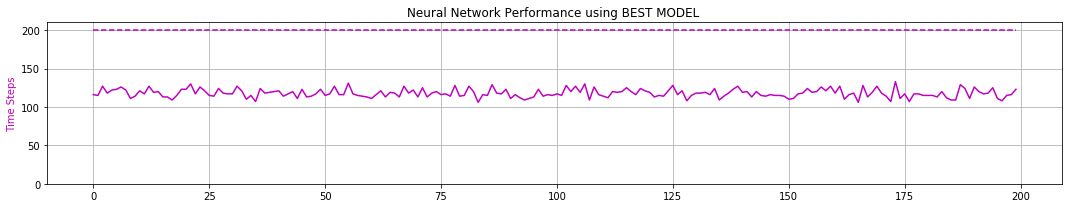

peak memory: 1438.68 MiB, increment: 978.53 MiB
0 -max- [ 0.143  0.813  0.046  1.033]
0 -min- [-2.393 -3.096 -0.209 -1.128]

1 -max- [ 0.143  0.751  0.048  0.964]
1 -min- [-2.374 -3.088 -0.209 -1.227]

2 -max- [ 0.140  0.634  0.049  0.992]
2 -min- [-2.376 -3.283 -0.209 -1.124]

3 -max- [ 0.133  0.794  0.049  0.960]
3 -min- [-2.356 -3.078 -0.209 -1.129]

4 -max- [ 0.160  0.634  0.049  1.036]
4 -min- [-2.377 -3.145 -0.209 -1.080]

5 -max- [ 0.144  0.744  0.050  0.990]
5 -min- [-2.358 -2.952 -0.209 -1.070]

6 -max- [ 0.167  0.634  0.048  0.951]
6 -min- [-2.385 -3.145 -0.209 -1.091]

7 -max- [ 0.128  0.632  0.048  0.973]
7 -min- [-2.348 -3.077 -0.209 -1.083]

8 -max- [ 0.161  0.763  0.051  0.974]
8 -min- [-2.398 -3.080 -0.209 -1.151]

9 -max- [ 0.132  0.634  0.049  0.929]
9 -min- [-2.375 -2.942 -0.209 -1.136]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   107097
SMALLEST TIMESTEP: 26
LARGEST  TIMESTEP: 124
TOTAL SERIAL TIMESTEPS:   887936
TOTAL PARALLEL TIM

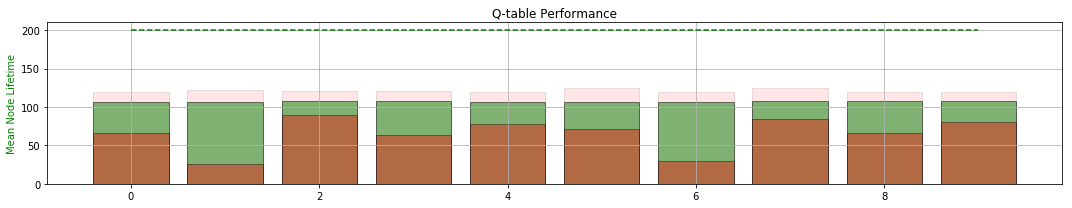

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 90.886	LOSS : 92.206	LOSS : 90.305	LOSS : 92.392	LOSS : 84.036	LOSS : 82.684	LOSS : 92.964	LOSS : 90.379	
Validating... MEAN TIME:  109.535
LOSS : 93.628	LOSS : 93.968	LOSS : 85.331	LOSS : 95.815	LOSS : 76.791	LOSS : 87.292	LOSS : 93.416	LOSS : 74.060	
Validating... MEAN TIME:  110.81
LOSS : 100.339	LOSS : 93.271	LOSS : 88.180	LOSS : 85.380	LOSS : 92.259	LOSS : 89.226	LOSS : 87.880	LOSS : 90.479	
Validating... MEAN TIME:  110.83
LOSS : 89.496	LOSS : 81.676	LOSS : 78.751	LOSS : 86.014	LOSS : 87.496	LOSS : 87.360	LOSS : 100.392	LOSS : 80.779	
Validating... MEAN TIME:  112.12
LOSS : 88.023	LOSS : 95.484	LOSS : 89.964	LOSS : 80.708	LOSS : 81.858	LOSS : 90.945	LOSS : 93.371	LOSS : 85.767	
Validating... MEAN TIME:  112.87
TRAINING TIME:0:00:50.347500


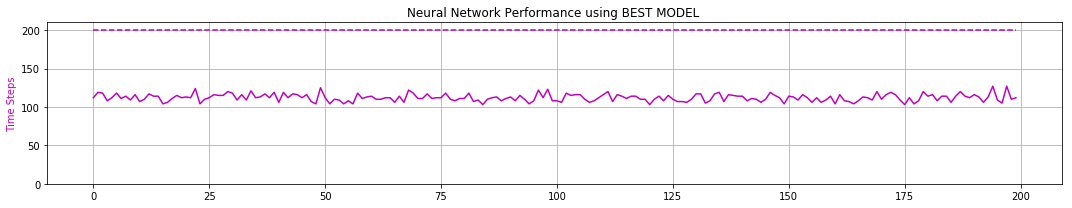

peak memory: 1432.19 MiB, increment: 1006.35 MiB
0 -max- [ 0.148  0.820  0.048  1.007]
0 -min- [-2.400 -3.165 -0.209 -1.166]

1 -max- [ 0.148  0.825  0.049  1.121]
1 -min- [-2.399 -3.166 -0.207 -1.158]

2 -max- [ 0.152  0.824  0.050  1.075]
2 -min- [-2.400 -3.166 -0.208 -1.162]

3 -max- [ 0.163  0.810  0.049  1.005]
3 -min- [-2.399 -3.161 -0.209 -1.177]

4 -max- [ 0.150  0.827  0.050  1.308]
4 -min- [-2.399 -3.154 -0.209 -1.200]

5 -max- [ 0.166  0.828  0.048  1.008]
5 -min- [-2.399 -3.146 -0.207 -1.208]

6 -max- [ 0.138  0.956  0.048  1.207]
6 -min- [-2.399 -3.168 -0.209 -1.387]

7 -max- [ 0.165  0.930  0.051  1.106]
7 -min- [-2.399 -3.168 -0.209 -1.414]

8 -max- [ 0.142  0.823  0.049  1.007]
8 -min- [-2.400 -3.306 -0.209 -1.427]

9 -max- [ 0.142  0.825  0.050  1.253]
9 -min- [-2.399 -3.163 -0.209 -1.213]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   95704
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   983640
TOTAL PARALLEL TIM

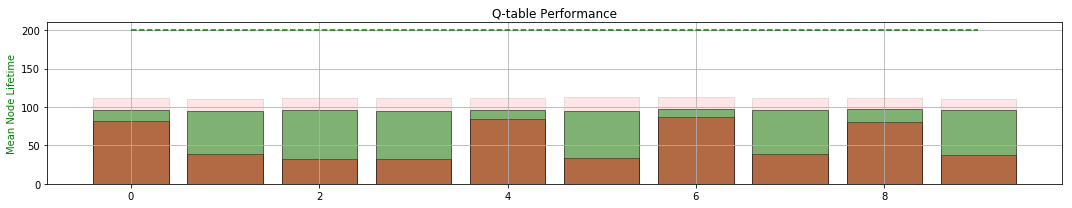

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 93.265	LOSS : 84.956	LOSS : 79.341	LOSS : 78.633	LOSS : 83.690	LOSS : 80.462	LOSS : 82.622	LOSS : 83.185	
Validating... MEAN TIME:  109.315
LOSS : 73.394	LOSS : 87.571	LOSS : 76.151	LOSS : 77.828	LOSS : 79.753	LOSS : 77.298	LOSS : 86.424	LOSS : 78.589	
Validating... MEAN TIME:  107.415
LOSS : 90.198	LOSS : 88.716	LOSS : 76.649	LOSS : 81.116	LOSS : 81.650	LOSS : 81.401	LOSS : 82.508	LOSS : 97.003	
Validating... MEAN TIME:  108.3
LOSS : 82.165	LOSS : 80.972	LOSS : 85.648	LOSS : 93.837	LOSS : 74.912	LOSS : 83.651	LOSS : 86.446	LOSS : 84.577	
Validating... MEAN TIME:  109.33
LOSS : 91.115	LOSS : 89.741	LOSS : 83.777	LOSS : 78.801	LOSS : 70.723	LOSS : 85.157	LOSS : 76.035	LOSS : 83.351	
Validating... MEAN TIME:  107.295
TRAINING TIME:0:00:48.816953


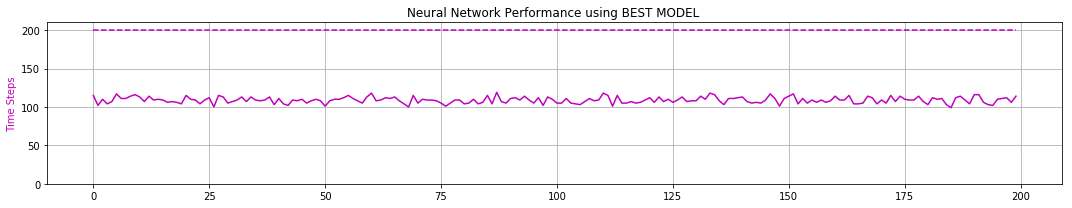

peak memory: 1472.61 MiB, increment: 978.29 MiB
0 -max- [ 0.140  0.949  0.049  0.868]
0 -min- [-2.363 -2.892 -0.209 -1.364]

1 -max- [ 0.136  1.019  0.049  0.829]
1 -min- [-2.156 -2.769 -0.209 -1.429]

2 -max- [ 0.155  0.990  0.049  0.697]
2 -min- [-2.353 -2.899 -0.209 -1.451]

3 -max- [ 0.148  0.966  0.050  0.852]
3 -min- [-2.349 -2.915 -0.209 -1.456]

4 -max- [ 0.161  0.828  0.048  0.852]
4 -min- [-2.271 -2.758 -0.209 -1.155]

5 -max- [ 0.141  0.947  0.048  0.823]
5 -min- [-2.307 -2.898 -0.209 -1.363]

6 -max- [ 0.157  0.930  0.051  0.845]
6 -min- [-2.305 -2.898 -0.209 -1.363]

7 -max- [ 0.129  0.823  0.049  0.690]
7 -min- [-2.204 -2.780 -0.209 -1.243]

8 -max- [ 0.136  0.950  0.050  0.822]
8 -min- [-2.394 -2.912 -0.209 -1.363]

9 -max- [ 0.154  1.017  0.050  0.873]
9 -min- [-2.327 -2.893 -0.209 -1.422]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   95771
SMALLEST TIMESTEP: 27
LARGEST  TIMESTEP: 112
TOTAL SERIAL TIMESTEPS:   1079411
TOTAL PARALLEL TI

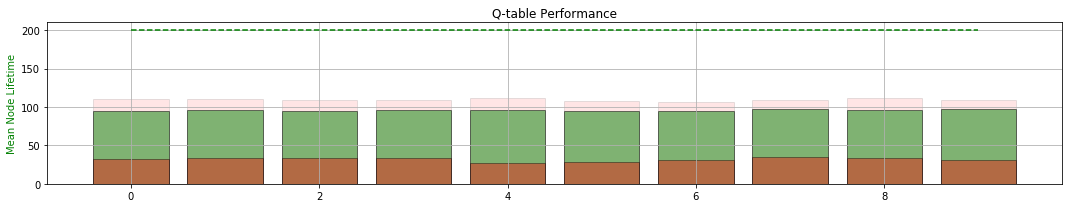

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 83.761	LOSS : 89.101	LOSS : 93.402	LOSS : 91.016	LOSS : 84.374	LOSS : 94.915	LOSS : 81.315	LOSS : 81.785	
Validating... MEAN TIME:  105.695
LOSS : 86.934	LOSS : 77.676	LOSS : 87.586	LOSS : 84.278	LOSS : 83.421	LOSS : 86.224	LOSS : 83.137	LOSS : 83.062	
Validating... MEAN TIME:  103.09
LOSS : 87.460	LOSS : 88.877	LOSS : 90.466	LOSS : 83.598	LOSS : 79.698	LOSS : 89.576	LOSS : 85.036	LOSS : 87.855	
Validating... MEAN TIME:  102.395
LOSS : 87.842	LOSS : 74.006	LOSS : 87.837	LOSS : 87.562	LOSS : 85.430	LOSS : 79.995	LOSS : 72.384	LOSS : 80.672	
Validating... MEAN TIME:  103.365
LOSS : 88.959	LOSS : 90.089	LOSS : 83.763	LOSS : 71.810	LOSS : 93.951	LOSS : 84.666	LOSS : 81.675	LOSS : 81.438	
Validating... MEAN TIME:  104.02
TRAINING TIME:0:00:43.732501


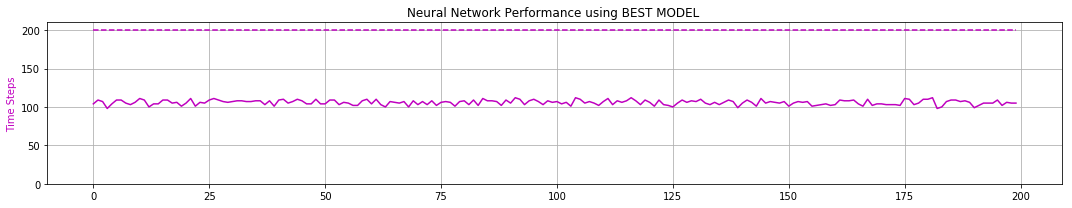

peak memory: 1489.06 MiB, increment: 1042.56 MiB
0 -max- [ 0.154  0.989  0.049  0.696]
0 -min- [-2.398 -2.970 -0.209 -1.366]

1 -max- [ 0.163  0.810  0.049  0.742]
1 -min- [-2.398 -2.966 -0.209 -1.171]

2 -max- [ 0.150  0.939  0.050  0.918]
2 -min- [-2.399 -3.102 -0.209 -1.354]

3 -max- [ 0.166  0.974  0.048  0.857]
3 -min- [-2.399 -3.123 -0.209 -1.400]

4 -max- [ 0.145  0.947  0.049  0.697]
4 -min- [-2.397 -3.074 -0.209 -1.363]

5 -max- [ 0.165  0.990  0.051  0.850]
5 -min- [-2.393 -3.089 -0.209 -1.370]

6 -max- [ 0.138  0.936  0.049  0.697]
6 -min- [-2.398 -2.960 -0.209 -1.336]

7 -max- [ 0.147  0.950  0.050  0.785]
7 -min- [-2.399 -3.132 -0.209 -1.363]

8 -max- [ 0.162  0.821  0.050  0.693]
8 -min- [-2.397 -2.960 -0.209 -1.167]

9 -max- [ 0.141  0.811  0.049  0.874]
9 -min- [-2.398 -3.092 -0.209 -1.171]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   44039
SMALLEST TIMESTEP: 18
LARGEST  TIMESTEP: 102
TOTAL SERIAL TIMESTEPS:   1123450
TOTAL PARALLEL T

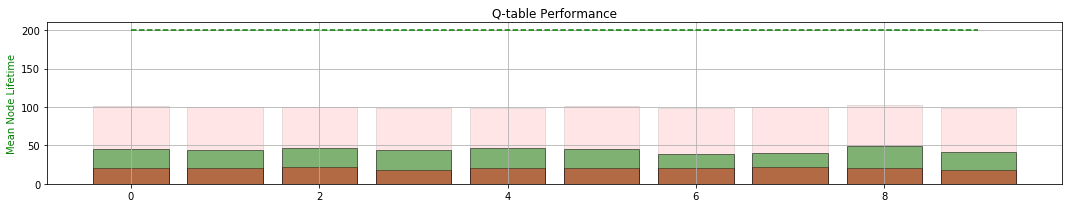

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 116.726	LOSS : 128.340	LOSS : 111.868	LOSS : 114.199	LOSS : 112.779	LOSS : 107.359	LOSS : 119.147	LOSS : 107.129	
Validating... MEAN TIME:  106.565
LOSS : 124.215	LOSS : 110.782	LOSS : 112.462	LOSS : 114.461	LOSS : 122.895	LOSS : 121.045	LOSS : 121.900	LOSS : 106.974	
Validating... MEAN TIME:  108.455
LOSS : 119.688	LOSS : 117.412	LOSS : 121.738	LOSS : 110.588	LOSS : 121.190	LOSS : 121.921	LOSS : 108.288	LOSS : 113.577	
Validating... MEAN TIME:  103.635
LOSS : 108.156	LOSS : 112.248	LOSS : 117.981	LOSS : 97.626	LOSS : 112.907	LOSS : 120.283	LOSS : 113.054	LOSS : 104.043	
Validating... MEAN TIME:  104.08
LOSS : 113.330	LOSS : 100.795	LOSS : 110.129	LOSS : 115.098	LOSS : 101.616	LOSS : 109.639	LOSS : 113.036	LOSS : 115.428	
Validating... MEAN TIME:  102.74
TRAINING TIME:0:00:45.563968


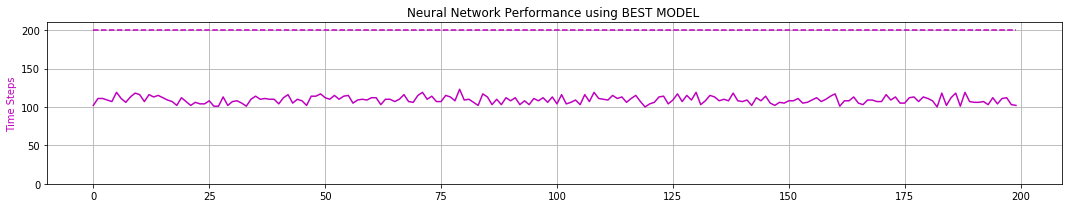

peak memory: 1411.43 MiB, increment: 1034.66 MiB
0 -max- [ 0.191  0.988  0.049  0.802]
0 -min- [-2.397 -2.970 -0.209 -1.414]

1 -max- [ 0.188  1.003  0.050  0.795]
1 -min- [-2.398 -2.963 -0.209 -1.435]

2 -max- [ 0.197  0.946  0.048  0.642]
2 -min- [-2.395 -3.089 -0.209 -1.408]

3 -max- [ 0.169  0.989  0.050  0.812]
3 -min- [-2.400 -2.972 -0.209 -1.446]

4 -max- [ 0.195  0.930  0.051  0.635]
4 -min- [-2.400 -2.972 -0.209 -1.363]

5 -max- [ 0.166  0.829  0.049  0.679]
5 -min- [-2.399 -3.086 -0.209 -1.191]

6 -max- [ 0.173  0.973  0.050  0.696]
6 -min- [-2.397 -2.965 -0.209 -1.363]

7 -max- [ 0.192  0.824  0.050  0.630]
7 -min- [-2.394 -3.077 -0.209 -1.183]

8 -max- [ 0.175  0.828  0.049  0.880]
8 -min- [-2.399 -3.101 -0.209 -1.184]

9 -max- [ 0.161  0.998  0.050  0.840]
9 -min- [-2.397 -2.961 -0.209 -1.389]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   98445
SMALLEST TIMESTEP: 25
LARGEST  TIMESTEP: 114
TOTAL SERIAL TIMESTEPS:   1221895
TOTAL PARALLEL T

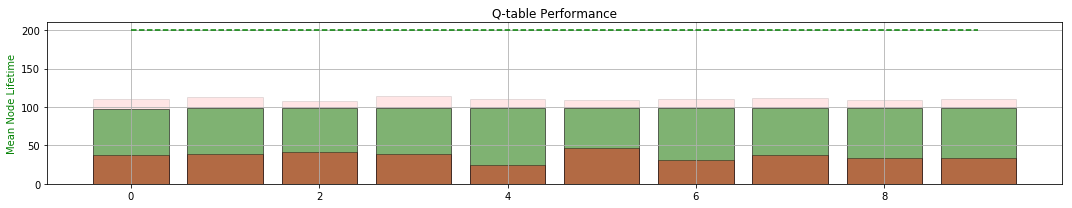

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 114.951	LOSS : 114.062	LOSS : 112.779	LOSS : 119.398	LOSS : 127.443	LOSS : 116.738	LOSS : 117.045	LOSS : 119.291	
Validating... MEAN TIME:  103.25
LOSS : 102.132	LOSS : 113.403	LOSS : 123.974	LOSS : 122.413	LOSS : 102.640	LOSS : 110.991	LOSS : 113.856	LOSS : 119.712	
Validating... MEAN TIME:  104.115
LOSS : 106.612	LOSS : 103.575	LOSS : 120.101	LOSS : 116.733	LOSS : 120.949	LOSS : 113.916	LOSS : 120.864	LOSS : 115.544	
Validating... MEAN TIME:  103.605
LOSS : 111.235	LOSS : 111.443	LOSS : 109.644	LOSS : 103.793	LOSS : 106.951	LOSS : 106.133	LOSS : 123.465	LOSS : 111.187	
Validating... MEAN TIME:  103.815
LOSS : 124.241	LOSS : 104.968	LOSS : 116.218	LOSS : 108.463	LOSS : 121.698	LOSS : 116.569	LOSS : 111.512	LOSS : 106.648	
Validating... MEAN TIME:  103.075
TRAINING TIME:0:00:46.598070


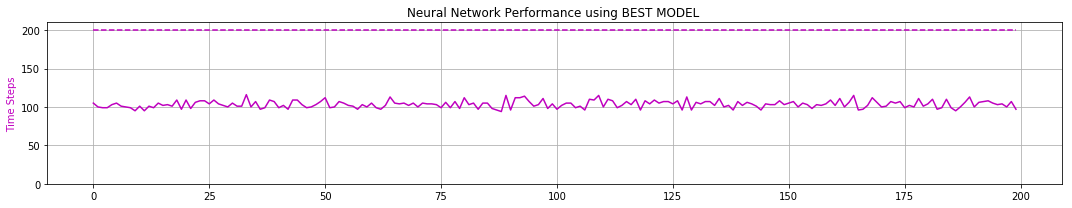

peak memory: 1445.29 MiB, increment: 1009.82 MiB
0 -max- [ 0.158  0.939  0.050  0.915]
0 -min- [-2.400 -3.179 -0.207 -1.354]

1 -max- [ 0.182  0.828  0.048  0.694]
1 -min- [-2.400 -3.170 -0.207 -1.155]

2 -max- [ 0.145  0.947  0.048  0.799]
2 -min- [-2.400 -3.171 -0.209 -1.430]

3 -max- [ 0.171  0.950  0.051  0.773]
3 -min- [-2.400 -3.168 -0.207 -1.432]

4 -max- [ 0.142  0.823  0.049  0.834]
4 -min- [-2.400 -3.151 -0.206 -1.181]

5 -max- [ 0.145  0.950  0.050  0.875]
5 -min- [-2.400 -3.170 -0.209 -1.363]

6 -max- [ 0.170  0.821  0.050  0.867]
6 -min- [-2.400 -3.168 -0.209 -1.167]

7 -max- [ 0.146  1.002  0.049  0.762]
7 -min- [-2.399 -3.168 -0.209 -1.450]

8 -max- [ 0.138  0.966  0.050  1.049]
8 -min- [-2.400 -3.169 -0.207 -1.359]

9 -max- [ 0.147  0.821  0.050  0.909]
9 -min- [-2.400 -3.289 -0.209 -1.166]

Quantization TIME:  0.01 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   81856
SMALLEST TIMESTEP: 37
LARGEST  TIMESTEP: 110
TOTAL SERIAL TIMESTEPS:   1303751
TOTAL PARALLEL T

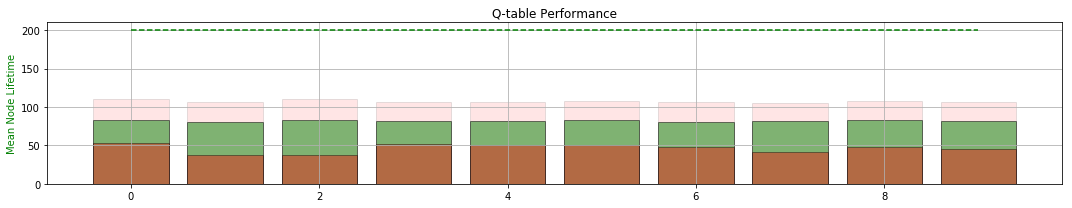

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 101.285	LOSS : 108.944	LOSS : 105.705	LOSS : 99.820	LOSS : 110.209	LOSS : 100.670	LOSS : 110.909	LOSS : 109.722	
Validating... MEAN TIME:  98.445
LOSS : 109.526	LOSS : 108.735	LOSS : 111.719	LOSS : 109.578	LOSS : 112.406	LOSS : 103.450	LOSS : 98.047	LOSS : 105.236	
Validating... MEAN TIME:  99.92
LOSS : 112.550	LOSS : 112.749	LOSS : 109.796	LOSS : 107.111	LOSS : 90.179	LOSS : 106.625	LOSS : 110.475	LOSS : 99.449	
Validating... MEAN TIME:  101.635
LOSS : 108.629	LOSS : 103.834	LOSS : 95.734	LOSS : 104.016	LOSS : 110.159	LOSS : 104.640	LOSS : 114.205	LOSS : 103.098	
Validating... MEAN TIME:  99.89
LOSS : 101.827	LOSS : 104.270	LOSS : 89.861	LOSS : 101.743	LOSS : 95.285	LOSS : 111.976	LOSS : 93.336	LOSS : 114.769	
Validating... MEAN TIME:  100.42
TRAINING TIME:0:00:45.328139


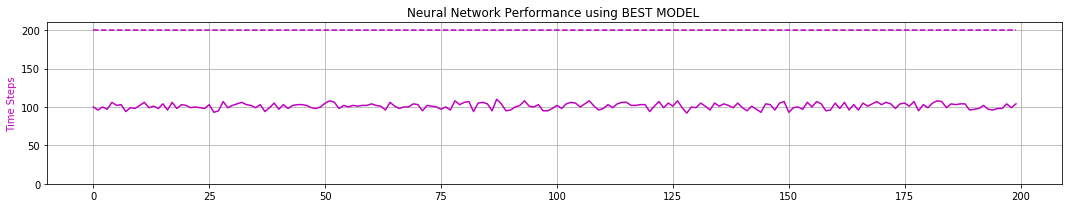

peak memory: 1449.49 MiB, increment: 999.26 MiB
0 -max- [ 0.182  0.828  0.048  0.768]
0 -min- [-2.398 -3.451 -0.209 -1.179]

1 -max- [ 0.153  0.964  0.048  0.683]
1 -min- [-2.399 -3.322 -0.209 -1.409]

2 -max- [ 0.165  0.930  0.051  0.679]
2 -min- [-2.398 -3.350 -0.209 -1.363]

3 -max- [ 0.152  0.829  0.049  0.902]
3 -min- [-2.398 -3.338 -0.209 -1.167]

4 -max- [ 0.144  1.008  0.050  0.772]
4 -min- [-2.397 -3.327 -0.209 -1.475]

5 -max- [ 0.170  0.824  0.050  0.678]
5 -min- [-2.395 -3.323 -0.209 -1.185]

6 -max- [ 0.161  0.986  0.061  0.684]
6 -min- [-2.397 -3.447 -0.209 -1.442]

7 -max- [ 0.138  1.022  0.050  0.710]
7 -min- [-2.398 -3.436 -0.209 -1.459]

8 -max- [ 0.146  0.827  0.050  0.733]
8 -min- [-2.399 -3.325 -0.209 -1.187]

9 -max- [ 0.144  0.934  0.050  0.685]
9 -min- [-2.395 -3.321 -0.209 -1.363]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   77888
SMALLEST TIMESTEP: 23
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   1381639
TOTAL PARALLEL TI

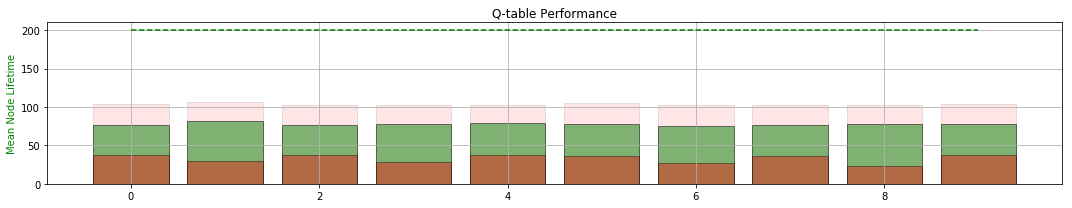

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 104.167	LOSS : 107.069	LOSS : 101.879	LOSS : 101.948	LOSS : 91.782	LOSS : 104.790	LOSS : 106.974	LOSS : 103.375	
Validating... MEAN TIME:  98.75
LOSS : 117.182	LOSS : 108.278	LOSS : 100.787	LOSS : 110.351	LOSS : 94.965	LOSS : 100.848	LOSS : 110.221	LOSS : 108.294	
Validating... MEAN TIME:  99.385
LOSS : 98.662	LOSS : 102.959	LOSS : 109.912	LOSS : 106.655	LOSS : 111.879	LOSS : 112.625	LOSS : 113.370	LOSS : 99.441	
Validating... MEAN TIME:  98.765
LOSS : 99.313	LOSS : 106.498	LOSS : 102.943	LOSS : 108.944	LOSS : 99.609	LOSS : 93.127	LOSS : 102.386	LOSS : 101.198	
Validating... MEAN TIME:  97.495
LOSS : 107.890	LOSS : 101.051	LOSS : 106.276	LOSS : 103.717	LOSS : 108.402	LOSS : 100.861	LOSS : 101.155	LOSS : 108.026	
Validating... MEAN TIME:  98.72
TRAINING TIME:0:00:44.491508


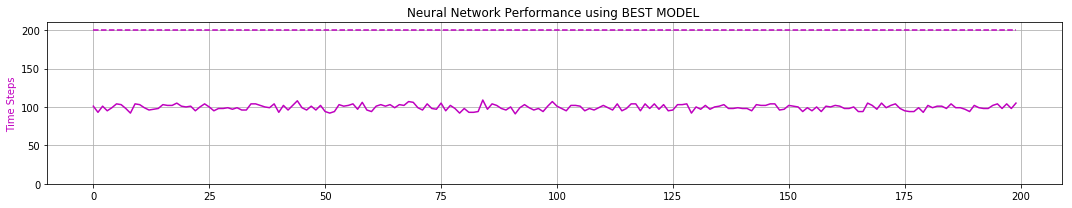

peak memory: 1485.77 MiB, increment: 973.11 MiB
0 -max- [ 0.158  0.976  0.048  0.851]
0 -min- [-2.398 -3.325 -0.209 -1.400]

1 -max- [ 0.182  1.021  0.051  0.780]
1 -min- [-2.399 -3.446 -0.209 -1.406]

2 -max- [ 0.160  0.829  0.050  0.899]
2 -min- [-2.400 -3.353 -0.209 -1.255]

3 -max- [ 0.189  0.963  0.050  0.874]
3 -min- [-2.399 -3.453 -0.209 -1.427]

4 -max- [ 0.180  0.975  0.050  0.834]
4 -min- [-2.399 -3.440 -0.209 -1.522]

5 -max- [ 0.160  0.829  0.049  0.906]
5 -min- [-2.398 -3.635 -0.209 -1.260]

6 -max- [ 0.149  0.965  0.050  0.689]
6 -min- [-2.400 -3.453 -0.209 -1.335]

7 -max- [ 0.169  0.830  0.050  0.805]
7 -min- [-2.400 -3.434 -0.209 -1.219]

8 -max- [ 0.157  0.941  0.050  0.691]
8 -min- [-2.400 -3.326 -0.209 -1.410]

9 -max- [ 0.168  0.827  0.048  0.795]
9 -min- [-2.400 -3.449 -0.209 -1.255]

Quantization TIME:  0.01 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   60726
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 101
TOTAL SERIAL TIMESTEPS:   1442365
TOTAL PARALLEL TI

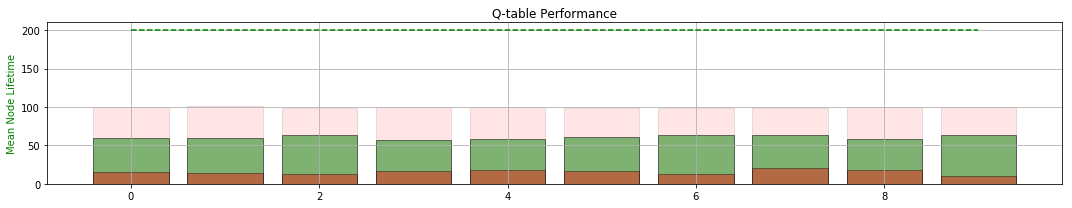

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 128.586	LOSS : 110.309	LOSS : 115.072	LOSS : 121.726	LOSS : 128.722	LOSS : 109.901	LOSS : 124.467	LOSS : 124.845	
Validating... MEAN TIME:  99.285
LOSS : 107.013	LOSS : 122.012	LOSS : 118.917	LOSS : 115.077	LOSS : 121.581	LOSS : 124.626	LOSS : 114.362	LOSS : 130.263	
Validating... MEAN TIME:  98.175
LOSS : 117.799	LOSS : 124.108	LOSS : 120.419	LOSS : 105.850	LOSS : 117.213	LOSS : 112.072	LOSS : 111.822	LOSS : 125.603	
Validating... MEAN TIME:  97.58
LOSS : 121.909	LOSS : 122.033	LOSS : 119.872	LOSS : 118.639	LOSS : 109.470	LOSS : 117.618	LOSS : 129.077	LOSS : 117.575	
Validating... MEAN TIME:  97.59
LOSS : 120.149	LOSS : 107.669	LOSS : 123.099	LOSS : 125.798	LOSS : 121.780	LOSS : 114.230	LOSS : 118.400	LOSS : 124.908	
Validating... MEAN TIME:  95.82
TRAINING TIME:0:00:46.347354


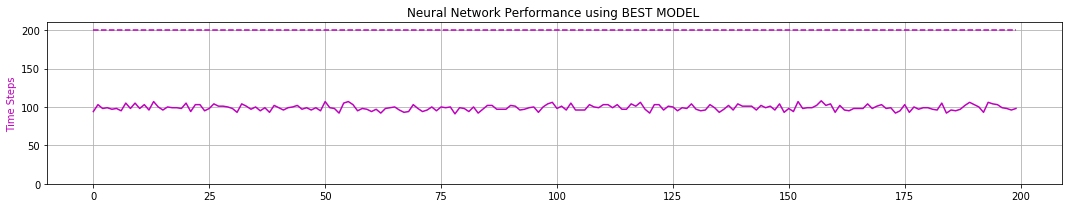

peak memory: 1431.07 MiB, increment: 1020.04 MiB
0 -max- [ 0.206  1.021  0.051  0.833]
0 -min- [-2.398 -3.263 -0.209 -1.375]

1 -max- [ 0.181  0.925  0.049  0.671]
1 -min- [-2.399 -3.238 -0.209 -1.403]

2 -max- [ 0.183  0.951  0.050  0.823]
2 -min- [-2.400 -3.440 -0.209 -1.378]

3 -max- [ 0.204  0.830  0.050  0.887]
3 -min- [-2.396 -3.437 -0.209 -1.282]

4 -max- [ 0.180  0.829  0.049  0.687]
4 -min- [-2.399 -3.446 -0.209 -1.225]

5 -max- [ 0.171  0.967  0.050  0.754]
5 -min- [-2.399 -3.248 -0.209 -1.452]

6 -max- [ 0.185  0.837  0.050  0.826]
6 -min- [-2.398 -3.471 -0.209 -1.305]

7 -max- [ 0.184  0.935  0.050  0.820]
7 -min- [-2.399 -3.319 -0.209 -1.374]

8 -max- [ 0.187  1.011  0.048  0.684]
8 -min- [-2.399 -3.439 -0.209 -1.374]

9 -max- [ 0.192  1.007  0.050  0.658]
9 -min- [-2.400 -3.438 -0.209 -1.608]

Quantization TIME:  0.01 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   63597
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 100
TOTAL SERIAL TIMESTEPS:   1505962
TOTAL PARALLEL T

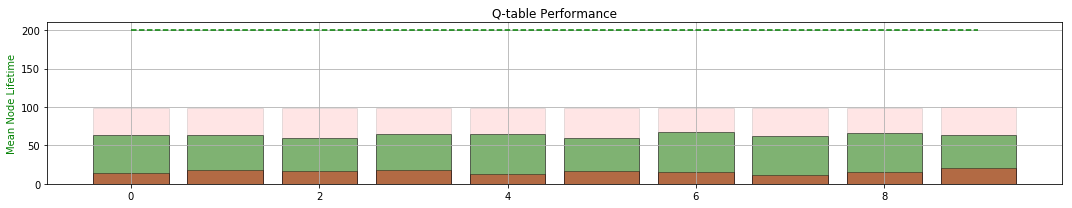

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 135.703	LOSS : 130.304	LOSS : 119.440	LOSS : 128.516	LOSS : 130.281	LOSS : 139.084	LOSS : 142.753	LOSS : 118.692	
Validating... MEAN TIME:  96.415
LOSS : 131.872	LOSS : 131.617	LOSS : 133.682	LOSS : 122.801	LOSS : 141.117	LOSS : 126.737	LOSS : 126.105	LOSS : 127.208	
Validating... MEAN TIME:  96.635
LOSS : 139.501	LOSS : 119.960	LOSS : 141.557	LOSS : 140.080	LOSS : 126.166	LOSS : 140.046	LOSS : 129.714	LOSS : 137.877	
Validating... MEAN TIME:  95.91
LOSS : 123.987	LOSS : 122.506	LOSS : 131.969	LOSS : 145.528	LOSS : 130.524	LOSS : 132.476	LOSS : 125.367	LOSS : 135.031	
Validating... MEAN TIME:  95.77
LOSS : 121.955	LOSS : 112.361	LOSS : 124.651	LOSS : 132.244	LOSS : 132.561	LOSS : 125.725	LOSS : 132.745	LOSS : 121.606	
Validating... MEAN TIME:  96.065
TRAINING TIME:0:00:45.530276


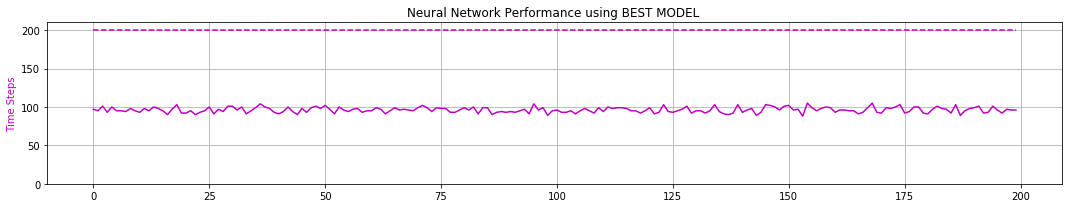

peak memory: 1431.48 MiB, increment: 977.91 MiB
0 -max- [ 0.168  1.010  0.049  0.687]
0 -min- [-2.392 -3.309 -0.209 -1.521]

1 -max- [ 0.183  0.967  0.050  0.825]
1 -min- [-2.400 -3.503 -0.209 -1.536]

2 -max- [ 0.204  1.012  0.050  0.778]
2 -min- [-2.396 -3.336 -0.209 -1.533]

3 -max- [ 0.189  0.984  0.049  0.718]
3 -min- [-2.396 -3.286 -0.209 -1.520]

4 -max- [ 0.171  0.966  0.050  0.810]
4 -min- [-2.396 -3.286 -0.209 -1.361]

5 -max- [ 0.185  0.976  0.050  0.776]
5 -min- [-2.400 -3.303 -0.209 -1.536]

6 -max- [ 0.184  1.129  0.050  0.776]
6 -min- [-2.395 -3.334 -0.209 -1.657]

7 -max- [ 0.200  1.015  0.048  0.673]
7 -min- [-2.385 -3.333 -0.209 -1.555]

8 -max- [ 0.205  1.027  0.050  0.681]
8 -min- [-2.398 -3.283 -0.209 -1.514]

9 -max- [ 0.221  1.160  0.050  0.747]
9 -min- [-2.400 -3.306 -0.209 -1.671]

Quantization TIME:  0.01 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   41694
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 77
TOTAL SERIAL TIMESTEPS:   1547656
TOTAL PARALLEL TIM

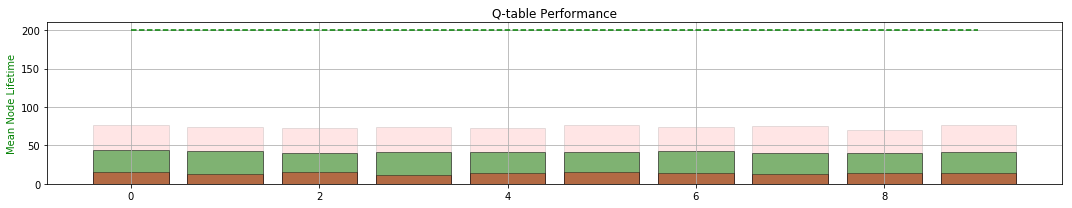

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 152.673	LOSS : 154.754	LOSS : 163.970	LOSS : 156.622	LOSS : 168.387	LOSS : 145.610	LOSS : 136.047	LOSS : 154.992	
Validating... MEAN TIME:  95.475
LOSS : 164.437	LOSS : 146.883	LOSS : 162.787	LOSS : 156.799	LOSS : 149.933	LOSS : 149.303	LOSS : 154.278	LOSS : 157.065	
Validating... MEAN TIME:  95.695
LOSS : 167.322	LOSS : 142.552	LOSS : 142.499	LOSS : 152.019	LOSS : 146.939	LOSS : 166.251	LOSS : 146.670	LOSS : 150.924	
Validating... MEAN TIME:  95.395
LOSS : 142.701	LOSS : 151.359	LOSS : 163.740	LOSS : 146.726	LOSS : 158.470	LOSS : 154.590	LOSS : 153.806	LOSS : 150.091	
Validating... MEAN TIME:  96.09
LOSS : 158.138	LOSS : 147.630	LOSS : 142.447	LOSS : 153.859	LOSS : 143.320	LOSS : 149.545	LOSS : 155.128	LOSS : 154.129	
Validating... MEAN TIME:  95.065
TRAINING TIME:0:00:45.058513


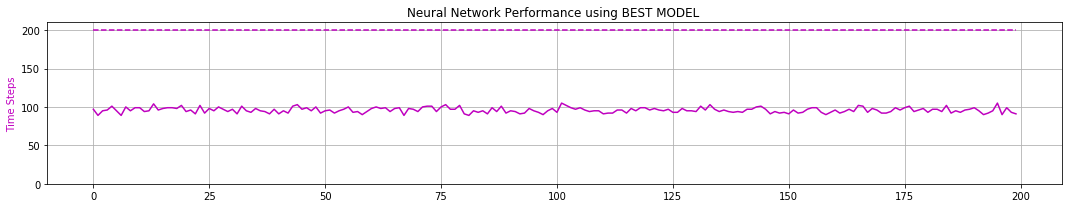

peak memory: 1467.43 MiB, increment: 974.36 MiB
0 -max- [ 0.191  1.020  0.050  0.666]
0 -min- [-1.367 -2.394 -0.209 -1.466]

1 -max- [ 0.204  0.998  0.050  0.666]
1 -min- [-1.117 -2.181 -0.209 -1.433]

2 -max- [ 0.184  1.170  0.049  0.670]
2 -min- [-1.136 -2.364 -0.209 -1.664]

3 -max- [ 0.186  1.127  0.050  0.508]
3 -min- [-1.264 -2.432 -0.209 -1.697]

4 -max- [ 0.193  1.016  0.050  0.677]
4 -min- [-1.174 -2.375 -0.209 -1.455]

5 -max- [ 0.184  1.208  0.050  0.599]
5 -min- [-1.396 -2.417 -0.209 -1.674]

6 -max- [ 0.195  1.020  0.048  0.676]
6 -min- [-1.395 -2.407 -0.209 -1.449]

7 -max- [ 0.205  1.019  0.050  0.668]
7 -min- [-1.265 -2.393 -0.209 -1.477]

8 -max- [ 0.202  1.215  0.053  0.688]
8 -min- [-1.307 -2.413 -0.209 -1.674]

9 -max- [ 0.183  1.013  0.049  0.675]
9 -min- [-1.346 -2.395 -0.209 -1.509]

Quantization TIME:  0.01 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   29574
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 96
TOTAL SERIAL TIMESTEPS:   1577230
TOTAL PARALLEL TIM

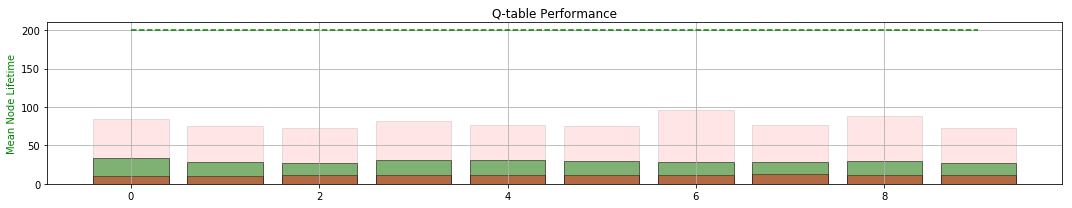

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 185.517	LOSS : 186.056	LOSS : 190.292	LOSS : 180.640	LOSS : 181.565	LOSS : 188.835	LOSS : 166.523	LOSS : 176.692	
Validating... MEAN TIME:  96.0
LOSS : 183.425	LOSS : 179.175	LOSS : 197.080	LOSS : 192.555	LOSS : 184.833	LOSS : 198.882	LOSS : 184.084	LOSS : 179.462	
Validating... MEAN TIME:  97.06
LOSS : 187.770	LOSS : 191.746	LOSS : 174.300	LOSS : 177.901	LOSS : 180.496	LOSS : 172.397	LOSS : 184.876	LOSS : 182.987	
Validating... MEAN TIME:  96.38
LOSS : 200.365	LOSS : 181.936	LOSS : 185.113	LOSS : 186.485	LOSS : 188.935	LOSS : 191.461	LOSS : 180.404	LOSS : 180.215	
Validating... MEAN TIME:  94.85
LOSS : 183.096	LOSS : 179.736	LOSS : 200.636	LOSS : 187.916	LOSS : 193.409	LOSS : 184.484	LOSS : 185.138	LOSS : 183.920	
Validating... MEAN TIME:  93.965
TRAINING TIME:0:00:45.643311


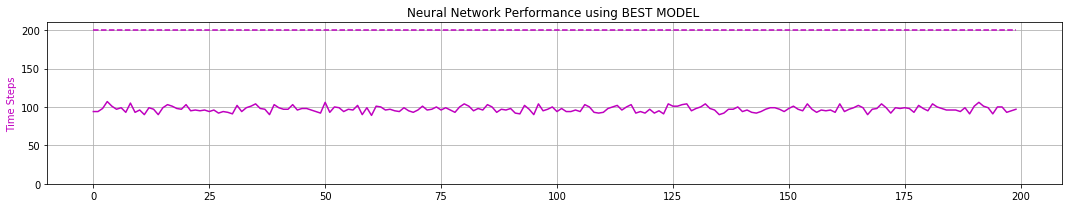

peak memory: 1413.50 MiB, increment: 1015.58 MiB
0 -max- [ 0.211  1.152  0.050  0.598]
0 -min- [-1.737 -2.701 -0.209 -1.677]

1 -max- [ 0.199  1.201  0.049  0.508]
1 -min- [-1.357 -2.408 -0.209 -1.750]

2 -max- [ 0.187  1.195  0.050  0.486]
2 -min- [-1.183 -2.233 -0.209 -1.677]

3 -max- [ 0.201  1.215  0.055  0.591]
3 -min- [-1.603 -2.722 -0.209 -1.678]

4 -max- [ 0.188  1.208  0.056  0.592]
4 -min- [-1.410 -2.518 -0.209 -1.674]

5 -max- [ 0.202  1.206  0.048  0.599]
5 -min- [-1.408 -2.531 -0.209 -1.680]

6 -max- [ 0.207  1.019  0.050  0.559]
6 -min- [-2.363 -3.257 -0.209 -1.477]

7 -max- [ 0.210  1.216  0.076  0.648]
7 -min- [-1.434 -2.589 -0.209 -1.684]

8 -max- [ 0.197  1.195  0.049  0.625]
8 -min- [-2.146 -3.143 -0.209 -1.679]

9 -max- [ 0.190  1.172  0.049  0.601]
9 -min- [-1.129 -2.353 -0.209 -1.677]

Quantization TIME:  0.01 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   35977
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 81
TOTAL SERIAL TIMESTEPS:   1613207
TOTAL PARALLEL TI

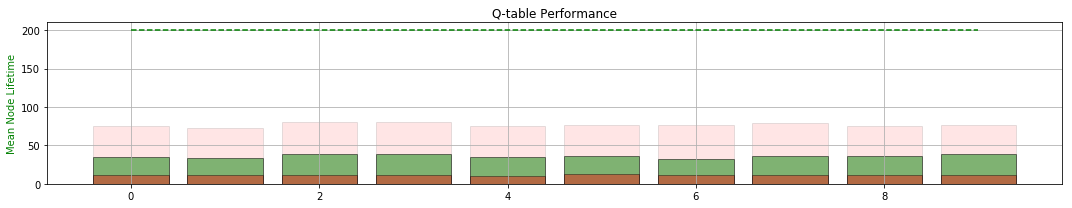

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 208.151	LOSS : 200.387	LOSS : 206.694	LOSS : 196.934	LOSS : 188.261	LOSS : 212.099	LOSS : 199.384	LOSS : 203.722	
Validating... MEAN TIME:  95.05
LOSS : 206.367	LOSS : 206.262	LOSS : 206.963	LOSS : 205.489	LOSS : 206.415	LOSS : 189.929	LOSS : 186.183	LOSS : 204.046	
Validating... MEAN TIME:  95.475
LOSS : 201.325	LOSS : 198.986	LOSS : 212.896	LOSS : 201.200	LOSS : 204.037	LOSS : 193.611	LOSS : 191.419	LOSS : 203.512	
Validating... MEAN TIME:  94.22
LOSS : 204.510	LOSS : 192.366	LOSS : 198.915	LOSS : 216.978	LOSS : 203.257	LOSS : 214.296	LOSS : 220.096	LOSS : 216.804	
Validating... MEAN TIME:  94.525
LOSS : 202.991	LOSS : 219.189	LOSS : 206.462	LOSS : 211.539	LOSS : 192.944	LOSS : 207.072	LOSS : 218.614	LOSS : 218.141	
Validating... MEAN TIME:  94.84
TRAINING TIME:0:00:45.220759


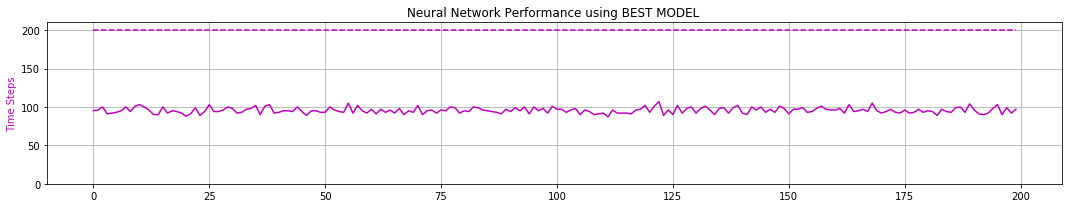

peak memory: 1462.32 MiB, increment: 1016.95 MiB
0 -max- [ 0.199  1.201  0.049  0.594]
0 -min- [-1.476 -2.609 -0.209 -1.678]

1 -max- [ 0.187  1.203  0.050  0.597]
1 -min- [-1.283 -2.412 -0.209 -1.743]

2 -max- [ 0.201  1.146  0.050  0.766]
2 -min- [-1.661 -2.773 -0.209 -1.716]

3 -max- [ 0.189  1.208  0.050  0.678]
3 -min- [-1.487 -2.603 -0.209 -1.674]

4 -max- [ 0.205  1.212  0.048  0.644]
4 -min- [-1.452 -2.587 -0.209 -1.680]

5 -max- [ 0.199  1.128  0.057  0.604]
5 -min- [-1.371 -2.415 -0.209 -1.635]

6 -max- [ 0.210  1.216  0.050  0.681]
6 -min- [-1.482 -2.418 -0.209 -1.684]

7 -max- [ 0.197  1.195  0.049  0.788]
7 -min- [-1.501 -2.612 -0.209 -1.712]

8 -max- [ 0.190  1.172  0.049  0.607]
8 -min- [-1.443 -2.420 -0.209 -1.677]

9 -max- [ 0.208  1.169  0.048  0.677]
9 -min- [-1.485 -2.595 -0.209 -1.680]

Quantization TIME:  0.01 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   31676
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 85
TOTAL SERIAL TIMESTEPS:   1644883
TOTAL PARALLEL TI

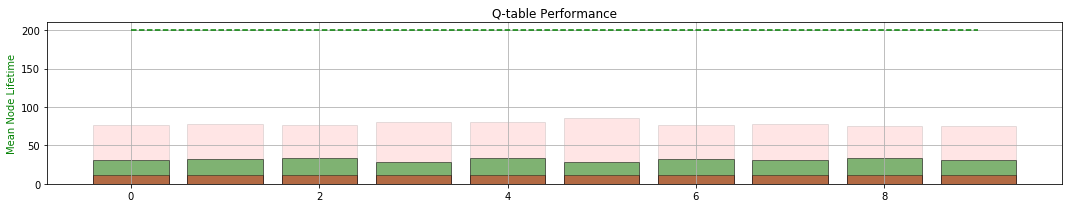

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 237.101	LOSS : 243.206	LOSS : 218.536	LOSS : 224.740	LOSS : 223.458	LOSS : 220.805	LOSS : 211.484	LOSS : 235.197	
Validating... MEAN TIME:  94.865
LOSS : 221.382	LOSS : 223.576	LOSS : 227.048	LOSS : 225.240	LOSS : 224.478	LOSS : 213.400	LOSS : 220.728	LOSS : 220.938	
Validating... MEAN TIME:  94.33
LOSS : 221.062	LOSS : 233.841	LOSS : 232.593	LOSS : 235.565	LOSS : 214.642	LOSS : 237.001	LOSS : 236.267	LOSS : 233.152	
Validating... MEAN TIME:  94.72
LOSS : 213.845	LOSS : 227.192	LOSS : 222.283	LOSS : 236.948	LOSS : 242.843	LOSS : 224.060	LOSS : 229.467	LOSS : 236.402	
Validating... MEAN TIME:  94.015
LOSS : 235.051	LOSS : 237.204	LOSS : 228.538	LOSS : 217.864	LOSS : 225.938	LOSS : 228.387	LOSS : 253.676	LOSS : 238.094	
Validating... MEAN TIME:  93.815
TRAINING TIME:0:00:46.003128


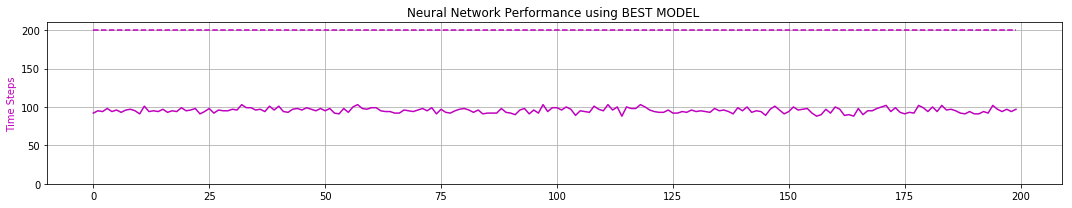

peak memory: 1421.48 MiB, increment: 1024.29 MiB
0 -max- [ 0.186  1.193  0.050  0.494]
0 -min- [-1.471 -2.612 -0.209 -1.677]

1 -max- [ 0.201  1.215  0.050  0.594]
1 -min- [-1.603 -2.701 -0.209 -1.678]

2 -max- [ 0.196  1.208  0.050  0.592]
2 -min- [-1.432 -2.518 -0.209 -1.674]

3 -max- [ 0.202  1.206  0.048  0.572]
3 -min- [-1.429 -2.567 -0.209 -1.680]

4 -max- [ 0.207  1.135  0.050  0.683]
4 -min- [-1.659 -2.782 -0.209 -1.756]

5 -max- [ 0.210  1.216  0.060  0.581]
5 -min- [-1.730 -2.690 -0.209 -1.751]

6 -max- [ 0.189  1.195  0.049  0.625]
6 -min- [-1.385 -2.569 -0.209 -1.679]

7 -max- [ 0.194  1.172  0.049  0.601]
7 -min- [-1.641 -2.753 -0.209 -1.677]

8 -max- [ 0.200  1.169  0.048  0.587]
8 -min- [-1.351 -2.421 -0.209 -1.680]

9 -max- [ 0.210  1.183  0.050  0.591]
9 -min- [-1.390 -2.408 -0.209 -1.704]

Quantization TIME:  0.01 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   30251
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 94
TOTAL SERIAL TIMESTEPS:   1675134
TOTAL PARALLEL TI

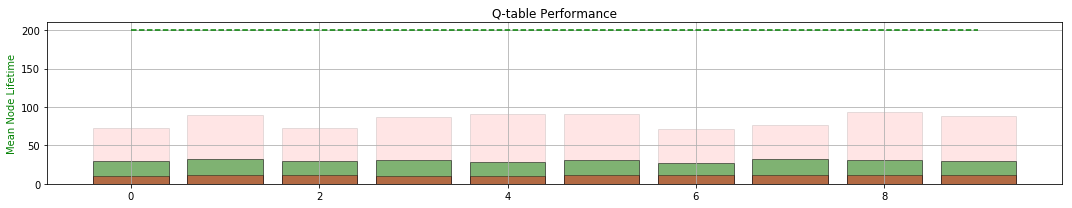

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 243.296	LOSS : 242.391	LOSS : 253.996	LOSS : 240.037	LOSS : 251.763	LOSS : 262.106	LOSS : 253.341	LOSS : 241.620	
Validating... MEAN TIME:  95.805
LOSS : 246.699	LOSS : 244.085	LOSS : 234.133	LOSS : 232.100	LOSS : 238.254	LOSS : 251.511	LOSS : 262.508	LOSS : 249.535	
Validating... MEAN TIME:  94.21
LOSS : 245.567	LOSS : 259.268	LOSS : 267.802	LOSS : 255.074	LOSS : 237.879	LOSS : 253.074	LOSS : 249.676	LOSS : 243.125	
Validating... MEAN TIME:  94.345
LOSS : 252.142	LOSS : 258.638	LOSS : 241.837	LOSS : 238.591	LOSS : 239.729	LOSS : 254.741	LOSS : 242.889	LOSS : 238.424	
Validating... MEAN TIME:  95.075
LOSS : 253.577	LOSS : 248.389	LOSS : 240.381	LOSS : 243.073	LOSS : 244.587	LOSS : 252.444	LOSS : 260.513	LOSS : 253.807	
Validating... MEAN TIME:  94.66
TRAINING TIME:0:00:45.792037


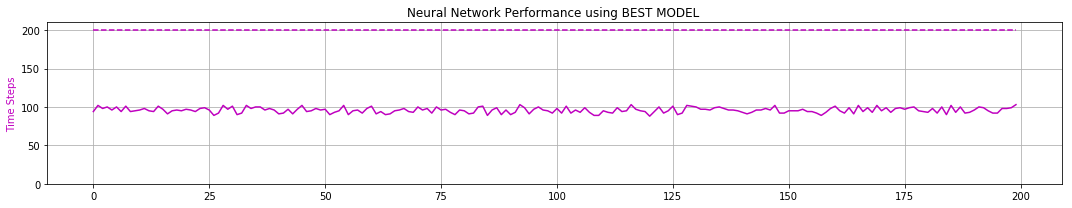

peak memory: 1471.50 MiB, increment: 1025.86 MiB
0 -max- [ 0.201  1.215  0.050  0.586]
0 -min- [-1.137 -2.361 -0.209 -1.678]

1 -max- [ 0.188  1.208  0.050  0.583]
1 -min- [-2.188 -3.144 -0.209 -1.674]

2 -max- [ 0.205  1.212  0.048  0.593]
2 -min- [-1.141 -2.330 -0.209 -1.687]

3 -max- [ 0.201  1.152  0.050  0.591]
3 -min- [-2.074 -2.927 -0.209 -1.744]

4 -max- [ 0.210  1.216  0.050  0.714]
4 -min- [-2.116 -2.930 -0.209 -1.684]

5 -max- [ 0.190  1.193  0.052  0.592]
5 -min- [-2.139 -3.113 -0.209 -1.679]

6 -max- [ 0.192  1.172  0.049  0.601]
6 -min- [-1.086 -2.166 -0.209 -1.677]

7 -max- [ 0.196  1.169  0.048  0.607]
7 -min- [-1.454 -2.606 -0.209 -1.680]

8 -max- [ 0.210  1.183  0.050  0.605]
8 -min- [-2.347 -3.135 -0.209 -1.713]

9 -max- [ 0.202  1.157  0.049  0.579]
9 -min- [-2.120 -2.934 -0.209 -1.657]

Quantization TIME:  0.01 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   36575
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 97
TOTAL SERIAL TIMESTEPS:   1711709
TOTAL PARALLEL TI

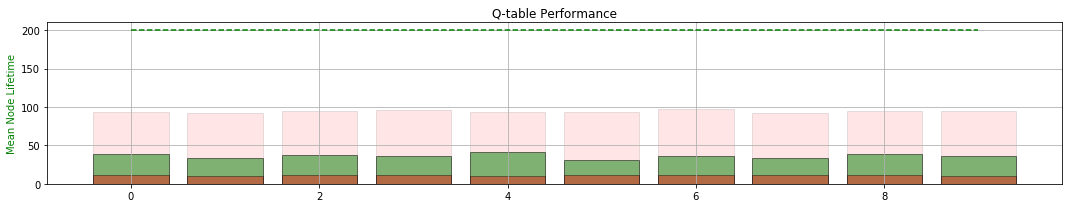

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 241.218	LOSS : 265.826	LOSS : 266.167	LOSS : 262.806	LOSS : 270.724	LOSS : 259.833	LOSS : 267.988	LOSS : 280.884	
Validating... MEAN TIME:  95.32
LOSS : 266.197	LOSS : 264.131	LOSS : 256.643	LOSS : 270.791	LOSS : 251.651	LOSS : 269.704	LOSS : 260.134	LOSS : 276.982	
Validating... MEAN TIME:  95.55
LOSS : 262.126	LOSS : 271.486	LOSS : 264.707	LOSS : 261.868	LOSS : 269.630	LOSS : 274.509	LOSS : 249.278	LOSS : 267.977	
Validating... MEAN TIME:  93.4
LOSS : 263.621	LOSS : 258.961	LOSS : 282.202	LOSS : 271.662	LOSS : 277.952	LOSS : 262.965	LOSS : 265.494	LOSS : 266.710	
Validating... MEAN TIME:  93.44
LOSS : 277.862	LOSS : 274.650	LOSS : 275.339	LOSS : 278.070	LOSS : 276.487	LOSS : 275.992	LOSS : 271.600	LOSS : 279.362	
Validating... MEAN TIME:  93.135
TRAINING TIME:0:00:44.671142


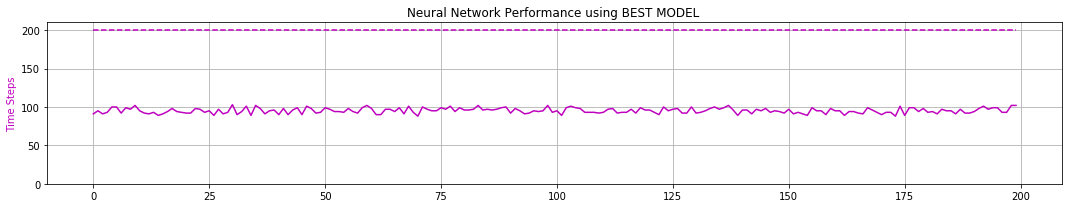

peak memory: 1427.52 MiB, increment: 1016.19 MiB
0 -max- [ 0.196  1.208  0.050  0.606]
0 -min- [-2.394 -3.167 -0.209 -1.674]

1 -max- [ 0.202  1.212  0.048  0.613]
1 -min- [-2.344 -3.106 -0.209 -1.680]

2 -max- [ 0.201  1.207  0.050  0.674]
2 -min- [-2.368 -3.147 -0.209 -1.773]

3 -max- [ 0.210  1.381  0.050  0.606]
3 -min- [-2.352 -3.145 -0.209 -1.968]

4 -max- [ 0.189  1.195  0.049  0.636]
4 -min- [-2.374 -3.154 -0.209 -1.686]

5 -max- [ 0.190  1.172  0.049  0.597]
5 -min- [-2.397 -3.104 -0.209 -1.677]

6 -max- [ 0.201  1.169  0.048  0.669]
6 -min- [-2.392 -3.157 -0.209 -1.723]

7 -max- [ 0.202  1.183  0.050  0.605]
7 -min- [-2.354 -2.945 -0.209 -1.677]

8 -max- [ 0.202  1.157  0.049  0.601]
8 -min- [-2.379 -3.251 -0.209 -1.657]

9 -max- [ 0.208  1.152  0.055  0.606]
9 -min- [-2.397 -3.102 -0.209 -1.675]

Quantization TIME:  0.01 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   32576
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 96
TOTAL SERIAL TIMESTEPS:   1744285
TOTAL PARALLEL TI

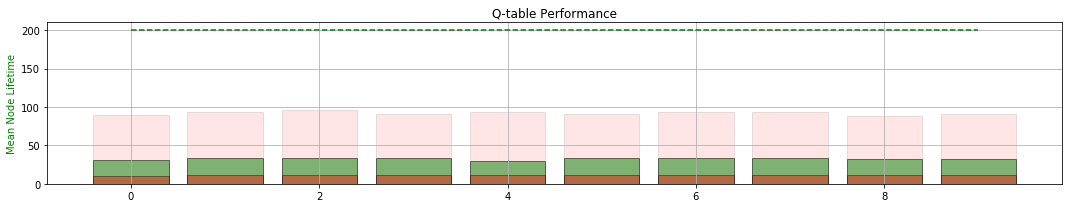

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 290.776	LOSS : 278.116	LOSS : 290.498	LOSS : 274.147	LOSS : 280.628	LOSS : 290.575	LOSS : 276.978	LOSS : 293.128	
Validating... MEAN TIME:  93.33
LOSS : 287.713	LOSS : 265.416	LOSS : 279.578	LOSS : 282.184	LOSS : 290.322	LOSS : 286.444	LOSS : 292.100	LOSS : 289.647	
Validating... MEAN TIME:  93.345
LOSS : 285.349	LOSS : 294.394	LOSS : 288.825	LOSS : 281.163	LOSS : 288.217	LOSS : 282.720	LOSS : 291.179	LOSS : 286.277	
Validating... MEAN TIME:  92.81
LOSS : 287.726	LOSS : 298.733	LOSS : 299.429	LOSS : 287.772	LOSS : 293.832	LOSS : 283.445	LOSS : 305.116	LOSS : 310.288	
Validating... MEAN TIME:  93.36
LOSS : 289.151	LOSS : 297.911	LOSS : 298.429	LOSS : 288.011	LOSS : 285.808	LOSS : 288.564	LOSS : 279.015	LOSS : 300.009	
Validating... MEAN TIME:  93.06
TRAINING TIME:0:00:44.163265


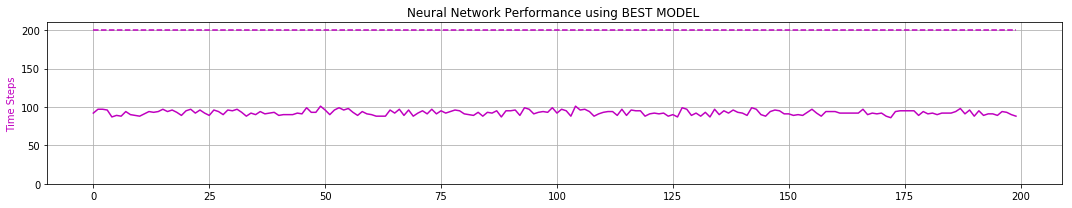

peak memory: 1413.00 MiB, increment: 1034.52 MiB
0 -max- [ 0.195  1.212  0.048  0.605]
0 -min- [-2.204 -2.947 -0.209 -1.722]

1 -max- [ 0.199  1.024  0.050  0.595]
1 -min- [-2.309 -3.151 -0.209 -1.537]

2 -max- [ 0.202  1.216  0.050  0.612]
2 -min- [-2.364 -3.142 -0.209 -1.684]

3 -max- [ 0.194  1.194  0.049  0.608]
3 -min- [-2.290 -3.141 -0.209 -1.679]

4 -max- [ 0.190  1.172  0.049  0.591]
4 -min- [-2.309 -3.088 -0.209 -1.677]

5 -max- [ 0.192  1.216  0.048  0.606]
5 -min- [-2.244 -2.960 -0.209 -1.720]

6 -max- [ 0.202  1.183  0.050  0.615]
6 -min- [-2.357 -3.148 -0.209 -1.677]

7 -max- [ 0.217  1.157  0.049  0.577]
7 -min- [-2.364 -3.092 -0.209 -1.657]

8 -max- [ 0.193  1.168  0.050  0.599]
8 -min- [-2.198 -2.893 -0.209 -1.715]

9 -max- [ 0.196  1.023  0.050  0.615]
9 -min- [-2.318 -2.945 -0.209 -1.491]

Quantization TIME:  0.01 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   24729
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 92
TOTAL SERIAL TIMESTEPS:   1769014
TOTAL PARALLEL TI

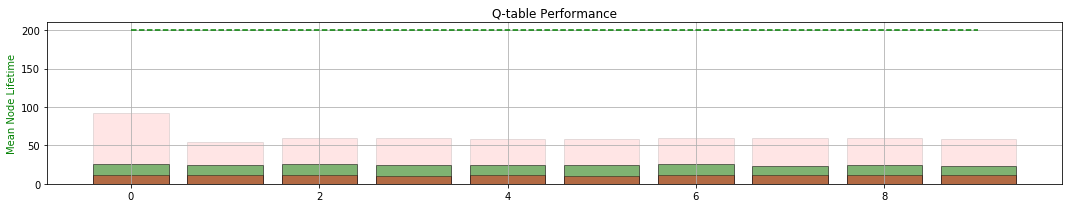

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 292.248	LOSS : 293.883	LOSS : 307.654	LOSS : 305.966	LOSS : 304.900	LOSS : 304.173	LOSS : 304.528	LOSS : 296.583	
Validating... MEAN TIME:  92.415
LOSS : 300.647	LOSS : 296.657	LOSS : 313.038	LOSS : 313.044	LOSS : 302.702	LOSS : 312.066	LOSS : 314.201	LOSS : 300.599	
Validating... MEAN TIME:  93.215
LOSS : 314.798	LOSS : 315.237	LOSS : 311.419	LOSS : 307.943	LOSS : 309.977	LOSS : 312.015	LOSS : 304.618	LOSS : 323.093	
Validating... MEAN TIME:  92.45
LOSS : 315.554	LOSS : 318.908	LOSS : 324.598	LOSS : 313.937	LOSS : 319.818	LOSS : 313.079	LOSS : 308.846	LOSS : 309.273	
Validating... MEAN TIME:  92.96
LOSS : 310.006	LOSS : 326.649	LOSS : 312.072	LOSS : 325.673	LOSS : 311.156	LOSS : 319.166	LOSS : 320.068	LOSS : 334.277	
Validating... MEAN TIME:  92.445
TRAINING TIME:0:00:43.749005


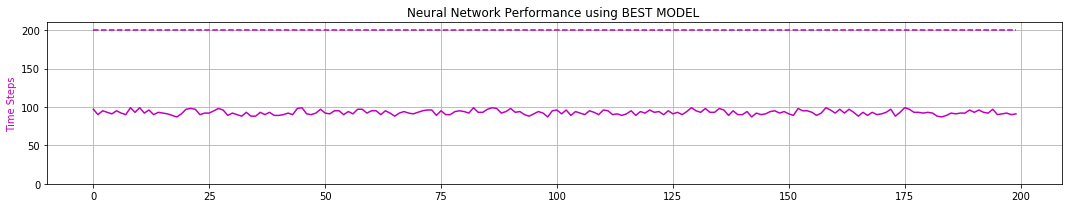

peak memory: 1414.46 MiB, increment: 977.28 MiB
0 -max- [ 0.205  1.134  0.050  0.551]
0 -min- [-2.354 -3.142 -0.209 -1.728]

1 -max- [ 0.210  1.216  0.050  0.558]
1 -min- [-0.549 -1.785 -0.209 -1.684]

2 -max- [ 0.197  1.193  0.052  0.518]
2 -min- [-0.730 -1.990 -0.209 -1.722]

3 -max- [ 0.194  1.172  0.049  0.484]
3 -min- [-0.781 -1.869 -0.209 -1.677]

4 -max- [ 0.196  1.169  0.048  0.495]
4 -min- [-0.772 -1.874 -0.209 -1.680]

5 -max- [ 0.210  1.183  0.050  0.481]
5 -min- [-0.656 -1.860 -0.209 -1.697]

6 -max- [ 0.202  1.335  0.051  0.564]
6 -min- [-0.744 -1.890 -0.209 -2.016]

7 -max- [ 0.208  1.168  0.050  0.481]
7 -min- [-0.743 -1.878 -0.209 -1.715]

8 -max- [ 0.190  1.023  0.050  0.502]
8 -min- [-0.780 -1.878 -0.209 -1.520]

9 -max- [ 0.200  1.161  0.049  0.592]
9 -min- [-0.756 -1.866 -0.209 -1.664]

Quantization TIME:  0.01 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   25289
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 73
TOTAL SERIAL TIMESTEPS:   1794303
TOTAL PARALLEL TIM

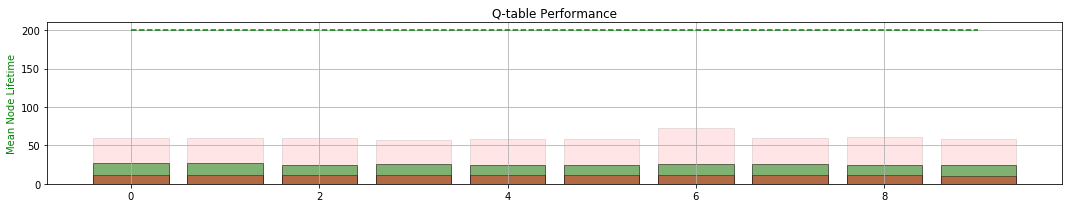

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 319.867	LOSS : 334.058	LOSS : 316.709	LOSS : 319.066	LOSS : 329.522	LOSS : 326.888	LOSS : 326.331	LOSS : 330.728	
Validating... MEAN TIME:  92.78
LOSS : 318.493	LOSS : 324.029	LOSS : 332.594	LOSS : 333.018	LOSS : 343.348	LOSS : 331.453	LOSS : 341.299	LOSS : 341.431	
Validating... MEAN TIME:  92.42
LOSS : 349.365	LOSS : 334.699	LOSS : 336.708	LOSS : 341.668	LOSS : 350.839	LOSS : 346.903	LOSS : 337.033	LOSS : 338.317	
Validating... MEAN TIME:  92.225
LOSS : 338.711	LOSS : 339.251	LOSS : 333.827	LOSS : 328.439	LOSS : 341.129	LOSS : 347.098	LOSS : 335.563	LOSS : 342.023	
Validating... MEAN TIME:  92.665
LOSS : 345.633	LOSS : 350.210	LOSS : 348.170	LOSS : 356.106	LOSS : 352.601	LOSS : 356.214	LOSS : 348.964	LOSS : 345.411	
Validating... MEAN TIME:  92.67
TRAINING TIME:0:00:44.373854


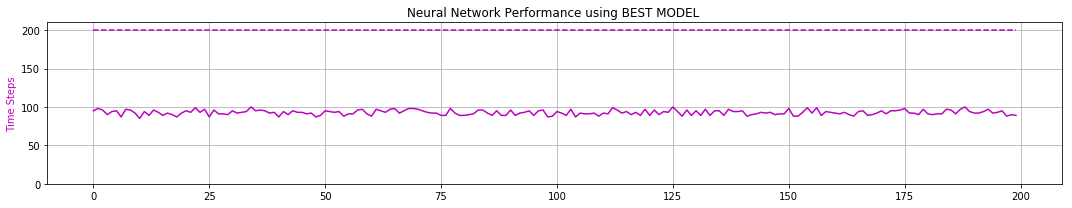

peak memory: 1429.72 MiB, increment: 1016.36 MiB
0 -max- [ 0.210  1.216  0.050  0.526]
0 -min- [-0.741 -1.869 -0.209 -1.684]

1 -max- [ 0.189  1.195  0.049  0.513]
1 -min- [-0.730 -1.990 -0.209 -1.686]

2 -max- [ 0.190  1.172  0.049  0.484]
2 -min- [-0.781 -1.870 -0.209 -1.677]

3 -max- [ 0.196  1.169  0.048  0.472]
3 -min- [-0.571 -1.833 -0.209 -1.680]

4 -max- [ 0.210  1.183  0.050  0.481]
4 -min- [-0.594 -1.838 -0.209 -1.677]

5 -max- [ 0.202  1.157  0.049  0.554]
5 -min- [-0.644 -1.858 -0.209 -1.693]

6 -max- [ 0.208  1.152  0.050  0.482]
6 -min- [-1.228 -2.418 -0.209 -1.675]

7 -max- [ 0.190  1.023  0.050  0.375]
7 -min- [-0.764 -1.878 -0.209 -1.491]

8 -max- [ 0.200  1.216  0.049  0.567]
8 -min- [-0.803 -1.871 -0.209 -1.695]

9 -max- [ 0.191  1.215  0.048  0.504]
9 -min- [-0.697 -1.861 -0.209 -1.669]

Quantization TIME:  0.01 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   22257
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 57
TOTAL SERIAL TIMESTEPS:   1816560
TOTAL PARALLEL TI

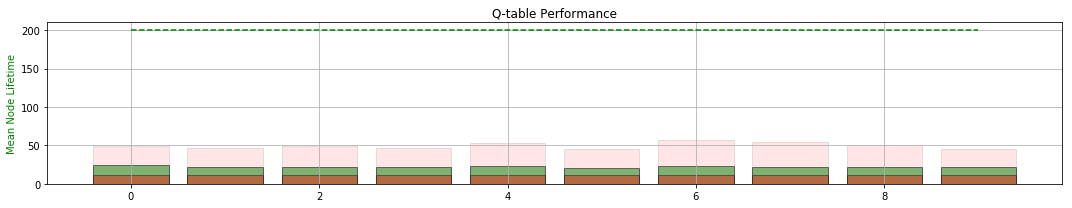

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 370.498	LOSS : 352.057	LOSS : 351.305	LOSS : 363.437	LOSS : 345.532	LOSS : 344.154	LOSS : 362.002	LOSS : 363.641	
Validating... MEAN TIME:  91.945
LOSS : 350.181	LOSS : 350.026	LOSS : 352.927	LOSS : 358.587	LOSS : 351.609	LOSS : 366.122	LOSS : 361.580	LOSS : 360.524	
Validating... MEAN TIME:  91.69
LOSS : 373.683	LOSS : 365.397	LOSS : 363.264	LOSS : 369.382	LOSS : 373.238	LOSS : 377.019	LOSS : 374.563	LOSS : 364.517	
Validating... MEAN TIME:  92.075
LOSS : 373.653	LOSS : 386.768	LOSS : 380.311	LOSS : 369.115	LOSS : 376.659	LOSS : 378.894	LOSS : 376.829	LOSS : 383.360	
Validating... MEAN TIME:  92.425
LOSS : 370.515	LOSS : 385.950	LOSS : 394.766	LOSS : 392.970	LOSS : 386.776	LOSS : 380.591	LOSS : 392.522	LOSS : 384.281	
Validating... MEAN TIME:  91.985
TRAINING TIME:0:00:45.636892


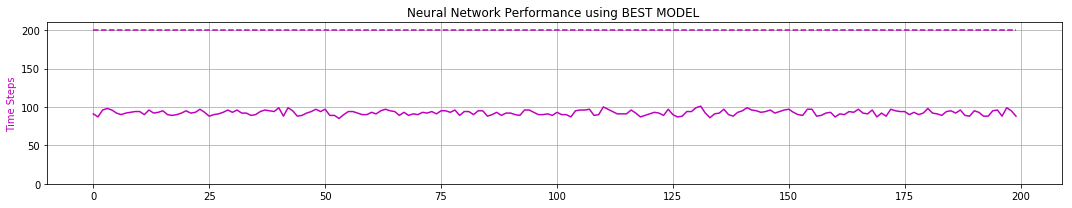

peak memory: 1466.16 MiB, increment: 1014.00 MiB
0 -max- [ 0.195  1.215  0.050  0.470]
0 -min- [-0.339 -1.485 -0.209 -1.707]

1 -max- [ 0.194  1.172  0.049  0.484]
1 -min- [-0.385 -1.605 -0.209 -1.677]

2 -max- [ 0.196  1.210  0.048  0.402]
2 -min- [-0.280 -1.467 -0.209 -1.703]

3 -max- [ 0.223  1.183  0.053  0.447]
3 -min- [-0.317 -1.510 -0.209 -1.697]

4 -max- [ 0.212  1.157  0.049  0.373]
4 -min- [-0.554 -1.826 -0.209 -1.657]

5 -max- [ 0.208  1.152  0.050  0.375]
5 -min- [-0.232 -1.278 -0.209 -1.741]

6 -max- [ 0.190  1.023  0.050  0.376]
6 -min- [-0.561 -1.858 -0.209 -1.521]

7 -max- [ 0.200  1.161  0.049  0.382]
7 -min- [-0.550 -1.791 -0.209 -1.664]

8 -max- [ 0.197  1.215  0.048  0.600]
8 -min- [-0.409 -1.607 -0.209 -1.669]

9 -max- [ 0.190  1.218  0.049  0.545]
9 -min- [-0.306 -1.477 -0.209 -1.674]

Quantization TIME:  0.01 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   21818
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 45
TOTAL SERIAL TIMESTEPS:   1838378
TOTAL PARALLEL TI

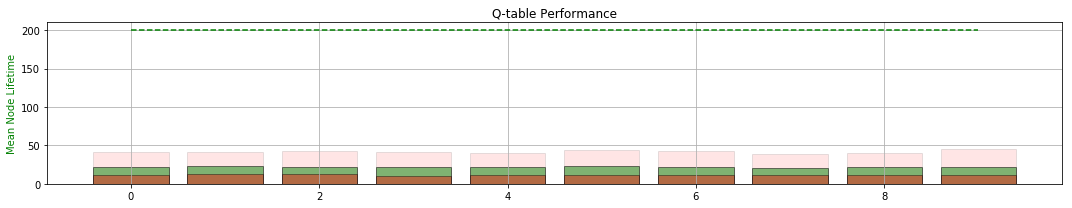

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 392.631	LOSS : 393.687	LOSS : 391.545	LOSS : 399.711	LOSS : 376.017	LOSS : 394.257	LOSS : 399.566	LOSS : 402.755	
Validating... MEAN TIME:  92.225
LOSS : 394.597	LOSS : 392.354	LOSS : 393.654	LOSS : 402.607	LOSS : 401.562	LOSS : 410.009	LOSS : 399.608	LOSS : 415.178	
Validating... MEAN TIME:  92.12
LOSS : 406.995	LOSS : 422.466	LOSS : 410.724	LOSS : 397.542	LOSS : 396.614	LOSS : 388.408	LOSS : 405.584	LOSS : 405.948	
Validating... MEAN TIME:  92.11
LOSS : 395.843	LOSS : 404.552	LOSS : 404.031	LOSS : 432.564	LOSS : 422.253	LOSS : 412.085	LOSS : 406.093	LOSS : 417.928	
Validating... MEAN TIME:  92.425
LOSS : 411.986	LOSS : 413.238	LOSS : 421.575	LOSS : 421.782	LOSS : 418.674	LOSS : 415.507	LOSS : 412.975	LOSS : 412.421	
Validating... MEAN TIME:  92.33
TRAINING TIME:0:00:44.214436


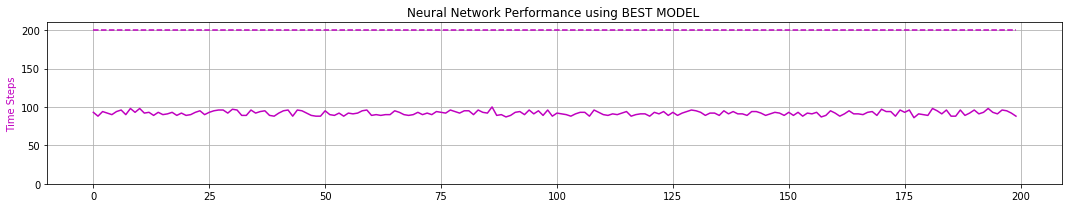

peak memory: 1394.78 MiB, increment: 962.05 MiB
0 -max- [ 0.197  1.172  0.049  0.484]
0 -min- [-0.170 -1.257 -0.209 -1.677]

1 -max- [ 0.200  1.191  0.051  0.513]
1 -min- [-0.145 -1.288 -0.209 -1.680]

2 -max- [ 0.218  1.183  0.050  0.543]
2 -min- [-0.137 -1.239 -0.209 -1.715]

3 -max- [ 0.209  1.201  0.052  0.465]
3 -min- [-0.152 -1.294 -0.209 -1.688]

4 -max- [ 0.201  1.152  0.050  0.373]
4 -min- [-0.132 -1.138 -0.209 -1.675]

5 -max- [ 0.190  1.023  0.050  0.550]
5 -min- [-0.172 -1.311 -0.209 -1.552]

6 -max- [ 0.200  1.161  0.049  0.496]
6 -min- [-0.241 -1.428 -0.209 -1.664]

7 -max- [ 0.199  1.215  0.048  0.376]
7 -min- [-0.140 -1.129 -0.209 -1.669]

8 -max- [ 0.194  1.218  0.049  0.374]
8 -min- [-0.174 -1.263 -0.209 -1.675]

9 -max- [ 0.198  1.184  0.053  0.375]
9 -min- [-0.140 -1.285 -0.209 -1.680]

Quantization TIME:  0.01 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   18239
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 55
TOTAL SERIAL TIMESTEPS:   1856617
TOTAL PARALLEL TIM

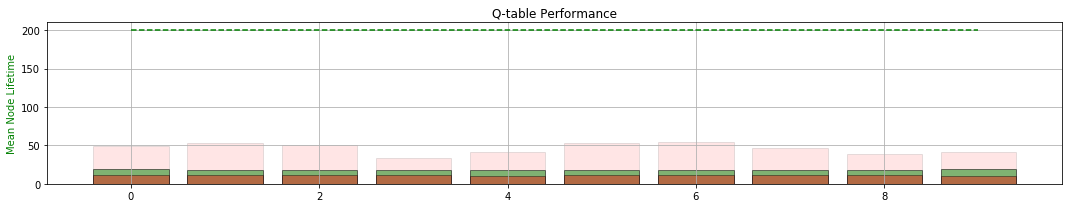

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 419.131	LOSS : 433.554	LOSS : 418.413	LOSS : 443.671	LOSS : 433.921	LOSS : 432.342	LOSS : 445.970	LOSS : 421.143	
Validating... MEAN TIME:  92.28
LOSS : 449.644	LOSS : 427.456	LOSS : 430.224	LOSS : 426.486	LOSS : 438.132	LOSS : 427.025	LOSS : 434.440	LOSS : 432.338	
Validating... MEAN TIME:  92.505
LOSS : 432.061	LOSS : 444.012	LOSS : 439.477	LOSS : 420.694	LOSS : 425.288	LOSS : 433.219	LOSS : 432.250	LOSS : 446.184	
Validating... MEAN TIME:  92.29
LOSS : 443.601	LOSS : 455.494	LOSS : 446.970	LOSS : 436.276	LOSS : 445.911	LOSS : 435.070	LOSS : 438.227	LOSS : 445.322	
Validating... MEAN TIME:  92.455
LOSS : 442.676	LOSS : 444.872	LOSS : 442.701	LOSS : 444.741	LOSS : 448.350	LOSS : 448.000	LOSS : 460.955	LOSS : 461.561	
Validating... MEAN TIME:  91.85
TRAINING TIME:0:00:45.318033


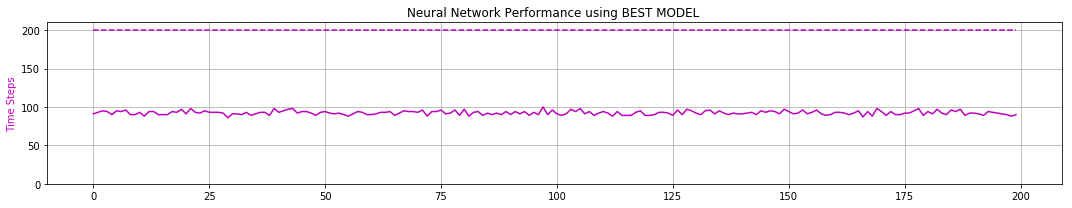

peak memory: 1468.52 MiB, increment: 977.34 MiB
0 -max- [ 0.208  1.169  0.048  0.349]
0 -min- [-0.468 -1.675 -0.209 -1.680]

1 -max- [ 0.218  1.183  0.050  0.373]
1 -min- [-0.614 -1.852 -0.209 -1.677]

2 -max- [ 0.210  1.157  0.049  0.368]
2 -min- [-0.523 -1.608 -0.209 -1.693]

3 -max- [ 0.210  1.152  0.050  0.367]
3 -min- [-0.120 -1.138 -0.209 -1.675]

4 -max- [ 0.201  1.143  0.050  0.358]
4 -min- [-0.338 -1.483 -0.209 -1.674]

5 -max- [ 0.210  1.194  0.049  0.357]
5 -min- [-0.627 -1.860 -0.209 -1.673]

6 -max- [ 0.199  1.215  0.048  0.589]
6 -min- [-0.607 -1.857 -0.209 -1.669]

7 -max- [ 0.202  1.357  0.049  0.358]
7 -min- [-0.336 -1.515 -0.209 -1.977]

8 -max- [ 0.209  1.184  0.050  0.508]
8 -min- [-0.194 -1.305 -0.209 -1.680]

9 -max- [ 0.212  1.355  0.050  0.503]
9 -min- [-0.199 -1.333 -0.209 -1.973]

Quantization TIME:  0.01 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   21175
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 79
TOTAL SERIAL TIMESTEPS:   1877792
TOTAL PARALLEL TIM

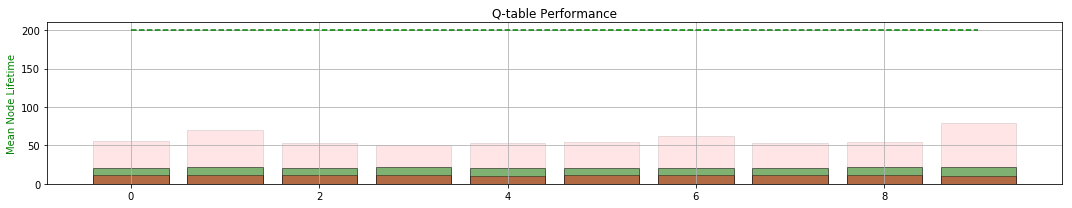

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 470.425	LOSS : 456.860	LOSS : 477.919	LOSS : 466.332	LOSS : 457.657	LOSS : 448.730	LOSS : 473.906	LOSS : 452.994	
Validating... MEAN TIME:  92.425
LOSS : 469.126	LOSS : 459.325	LOSS : 460.774	LOSS : 459.694	LOSS : 450.274	LOSS : 482.394	LOSS : 468.945	LOSS : 473.719	
Validating... MEAN TIME:  91.9
LOSS : 465.851	LOSS : 470.063	LOSS : 462.313	LOSS : 458.011	LOSS : 455.483	LOSS : 469.234	LOSS : 474.889	LOSS : 469.680	
Validating... MEAN TIME:  91.86
LOSS : 452.061	LOSS : 458.754	LOSS : 473.853	LOSS : 490.641	LOSS : 477.220	LOSS : 484.552	LOSS : 495.846	LOSS : 485.027	
Validating... MEAN TIME:  92.295
LOSS : 487.729	LOSS : 505.913	LOSS : 494.916	LOSS : 488.552	LOSS : 486.400	LOSS : 472.662	LOSS : 492.860	LOSS : 501.415	
Validating... MEAN TIME:  92.065
TRAINING TIME:0:00:43.968912


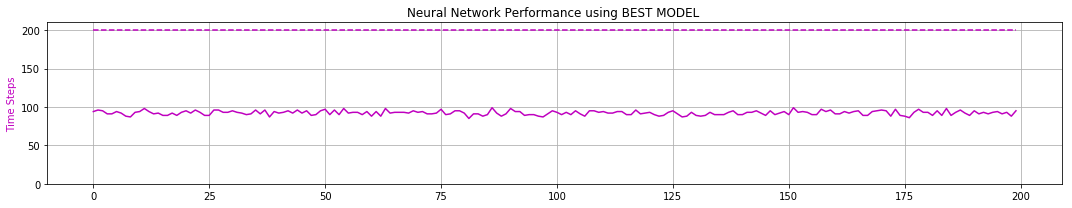

peak memory: 1410.84 MiB, increment: 1034.23 MiB
0 -max- [ 0.218  1.183  0.050  0.374]
0 -min- [-0.600 -1.871 -0.209 -1.677]

1 -max- [ 0.210  1.157  0.049  0.375]
1 -min- [-1.131 -2.405 -0.209 -1.657]

2 -max- [ 0.210  1.152  0.050  0.370]
2 -min- [-0.590 -1.833 -0.209 -1.675]

3 -max- [ 0.201  1.143  0.050  0.550]
3 -min- [-0.433 -1.636 -0.209 -1.674]

4 -max- [ 0.210  1.194  0.049  0.579]
4 -min- [-0.627 -1.860 -0.209 -1.673]

5 -max- [ 0.199  1.215  0.048  0.376]
5 -min- [-0.607 -1.857 -0.209 -1.669]

6 -max- [ 0.202  1.218  0.049  0.373]
6 -min- [-0.885 -2.205 -0.209 -1.675]

7 -max- [ 0.209  1.195  0.050  0.376]
7 -min- [-0.610 -1.852 -0.209 -1.723]

8 -max- [ 0.208  1.402  0.050  0.518]
8 -min- [-0.575 -1.818 -0.209 -1.967]

9 -max- [ 0.215  1.193  0.050  0.534]
9 -min- [-1.510 -2.702 -0.209 -1.706]

Quantization TIME:  0.01 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   21305
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 70
TOTAL SERIAL TIMESTEPS:   1899097
TOTAL PARALLEL TI

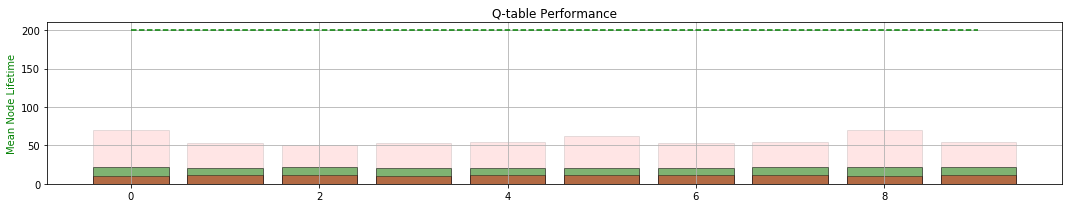

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 462.339	LOSS : 499.727	LOSS : 461.645	LOSS : 491.051	LOSS : 486.309	LOSS : 487.691	LOSS : 495.971	LOSS : 493.279	
Validating... MEAN TIME:  92.355
LOSS : 482.114	LOSS : 487.462	LOSS : 500.064	LOSS : 502.060	LOSS : 492.580	LOSS : 507.156	LOSS : 489.265	LOSS : 497.718	
Validating... MEAN TIME:  91.72
LOSS : 522.402	LOSS : 500.724	LOSS : 503.839	LOSS : 488.990	LOSS : 498.108	LOSS : 492.351	LOSS : 497.058	LOSS : 460.676	
Validating... MEAN TIME:  92.235
LOSS : 469.837	LOSS : 489.723	LOSS : 490.579	LOSS : 510.595	LOSS : 499.550	LOSS : 485.514	LOSS : 479.086	LOSS : 484.299	
Validating... MEAN TIME:  92.29
LOSS : 497.147	LOSS : 498.490	LOSS : 504.678	LOSS : 529.279	LOSS : 506.242	LOSS : 521.879	LOSS : 495.724	LOSS : 504.812	
Validating... MEAN TIME:  92.34
TRAINING TIME:0:00:45.130932


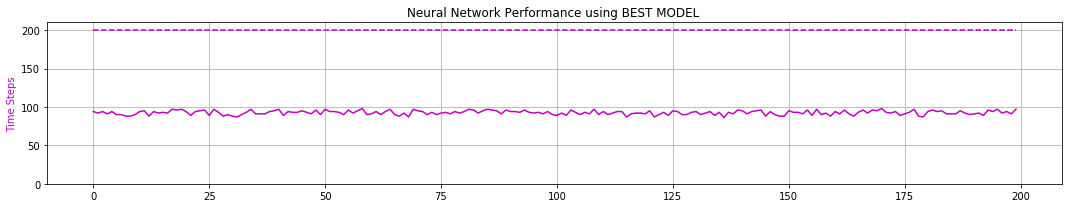

peak memory: 1421.30 MiB, increment: 977.81 MiB
0 -max- [ 0.210  1.157  0.049  0.376]
0 -min- [-1.131 -2.405 -0.209 -1.657]

1 -max- [ 0.210  1.152  0.050  0.370]
1 -min- [-0.590 -1.833 -0.209 -1.675]

2 -max- [ 0.201  1.143  0.050  0.550]
2 -min- [-0.433 -1.636 -0.209 -1.674]

3 -max- [ 0.210  1.194  0.049  0.579]
3 -min- [-0.627 -1.860 -0.209 -1.673]

4 -max- [ 0.199  1.215  0.048  0.376]
4 -min- [-0.607 -1.857 -0.209 -1.669]

5 -max- [ 0.202  1.218  0.049  0.373]
5 -min- [-0.885 -2.205 -0.209 -1.675]

6 -max- [ 0.209  1.195  0.050  0.376]
6 -min- [-0.610 -1.852 -0.209 -1.723]

7 -max- [ 0.208  1.402  0.050  0.518]
7 -min- [-0.575 -1.818 -0.209 -1.967]

8 -max- [ 0.215  1.195  0.050  0.545]
8 -min- [-1.069 -2.340 -0.209 -1.755]

9 -max- [ 0.216  1.211  0.050  0.472]
9 -min- [-0.586 -1.842 -0.209 -1.678]

Quantization TIME:  0.01 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   18101
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 67
TOTAL SERIAL TIMESTEPS:   1917198
TOTAL PARALLEL TIM

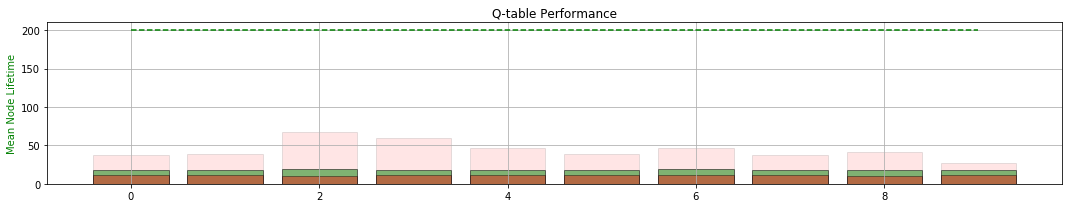

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 494.949	LOSS : 503.666	LOSS : 479.674	LOSS : 489.032	LOSS : 474.266	LOSS : 473.169	LOSS : 491.357	LOSS : 500.000	
Validating... MEAN TIME:  92.89
LOSS : 478.729	LOSS : 474.404	LOSS : 490.496	LOSS : 483.437	LOSS : 476.489	LOSS : 489.832	LOSS : 493.465	LOSS : 494.691	
Validating... MEAN TIME:  93.035
LOSS : 500.284	LOSS : 480.347	LOSS : 481.768	LOSS : 475.152	LOSS : 503.979	LOSS : 481.428	LOSS : 493.643	LOSS : 503.983	
Validating... MEAN TIME:  92.88
LOSS : 502.609	LOSS : 504.798	LOSS : 494.108	LOSS : 509.102	LOSS : 507.917	LOSS : 494.565	LOSS : 500.526	LOSS : 496.139	
Validating... MEAN TIME:  93.26
LOSS : 523.089	LOSS : 504.100	LOSS : 512.834	LOSS : 515.089	LOSS : 516.590	LOSS : 518.005	LOSS : 508.487	LOSS : 503.078	
Validating... MEAN TIME:  92.705
TRAINING TIME:0:00:45.805078


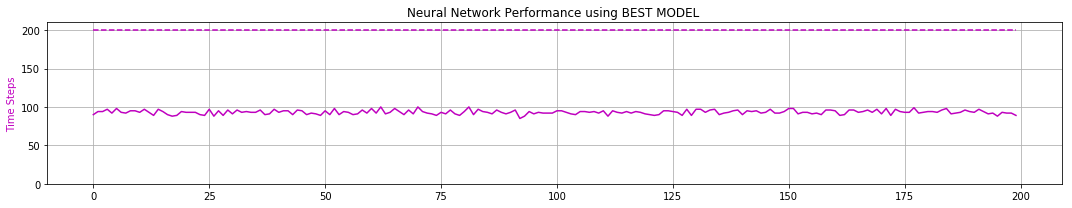

peak memory: 1462.75 MiB, increment: 1068.88 MiB
0 -max- [ 0.210  1.152  0.050  0.367]
0 -min- [-0.236 -1.321 -0.209 -1.675]

1 -max- [ 0.201  1.143  0.050  0.374]
1 -min- [-0.186 -1.313 -0.209 -1.674]

2 -max- [ 0.210  1.194  0.049  0.370]
2 -min- [-1.198 -2.402 -0.209 -1.673]

3 -max- [ 0.199  1.215  0.048  0.589]
3 -min- [-0.791 -2.039 -0.209 -1.712]

4 -max- [ 0.202  1.218  0.049  0.358]
4 -min- [-0.336 -1.515 -0.209 -1.675]

5 -max- [ 0.209  1.184  0.050  0.376]
5 -min- [-0.194 -1.305 -0.209 -1.680]

6 -max- [ 0.212  1.210  0.050  0.375]
6 -min- [-0.479 -1.676 -0.209 -1.718]

7 -max- [ 0.215  1.193  0.050  0.401]
7 -min- [-0.147 -1.150 -0.209 -1.788]

8 -max- [ 0.216  1.212  0.054  0.369]
8 -min- [-0.240 -1.336 -0.209 -1.699]

9 -max- [ 0.193  1.177  0.048  0.369]
9 -min- [-0.047 -0.789 -0.209 -1.759]

Quantization TIME:  0.01 minutes


ITERATION # 32
TOTAL EXPERIENCE GENERATED:   24471
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 92
TOTAL SERIAL TIMESTEPS:   1941669
TOTAL PARALLEL TIM

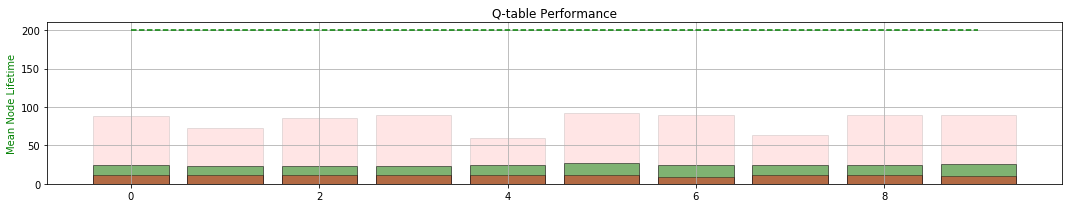

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 507.220	LOSS : 516.754	LOSS : 511.674	LOSS : 501.640	LOSS : 493.780	LOSS : 473.493	LOSS : 507.941	LOSS : 508.298	
Validating... MEAN TIME:  93.295
LOSS : 498.879	LOSS : 489.313	LOSS : 520.115	LOSS : 503.122	LOSS : 510.519	LOSS : 508.697	LOSS : 502.093	LOSS : 498.478	
Validating... MEAN TIME:  93.67
LOSS : 509.750	LOSS : 518.329	LOSS : 522.737	LOSS : 514.435	LOSS : 513.861	LOSS : 539.419	LOSS : 536.833	LOSS : 503.631	
Validating... MEAN TIME:  93.305
LOSS : 541.517	LOSS : 522.629	LOSS : 541.706	LOSS : 533.925	LOSS : 589.099	LOSS : 546.350	LOSS : 551.885	LOSS : 558.151	
Validating... MEAN TIME:  92.92
LOSS : 565.202	LOSS : 562.872	LOSS : 554.343	LOSS : 535.031	LOSS : 591.156	LOSS : 596.320	LOSS : 599.985	LOSS : 566.312	
Validating... MEAN TIME:  92.575
TRAINING TIME:0:00:42.916107


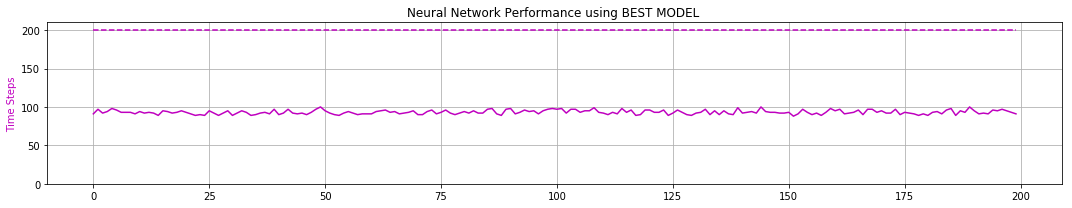

peak memory: 1426.21 MiB, increment: 978.91 MiB
0 -max- [ 0.201  1.219  0.050  0.552]
0 -min- [-2.377 -3.270 -0.209 -1.681]

1 -max- [ 0.210  1.194  0.049  0.375]
1 -min- [-1.441 -2.583 -0.209 -1.673]

2 -max- [ 0.207  1.215  0.048  0.535]
2 -min- [-2.342 -3.298 -0.209 -1.774]

3 -max- [ 0.202  1.218  0.049  0.374]
3 -min- [-2.344 -3.292 -0.209 -1.772]

4 -max- [ 0.209  1.184  0.050  0.575]
4 -min- [-0.973 -2.198 -0.209 -1.680]

5 -max- [ 0.212  1.210  0.050  0.550]
5 -min- [-2.377 -3.330 -0.209 -1.682]

6 -max- [ 0.207  1.207  0.050  0.565]
6 -min- [-2.384 -3.283 -0.209 -1.950]

7 -max- [ 0.216  1.211  0.050  0.557]
7 -min- [-0.983 -2.221 -0.209 -1.727]

8 -max- [ 0.193  1.200  0.048  0.564]
8 -min- [-2.378 -3.287 -0.209 -1.680]

9 -max- [ 0.200  1.159  0.050  0.521]
9 -min- [-2.394 -3.302 -0.209 -1.692]

Quantization TIME:  0.02 minutes


ITERATION # 33
TOTAL EXPERIENCE GENERATED:   21647
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 92
TOTAL SERIAL TIMESTEPS:   1963316
TOTAL PARALLEL TIM

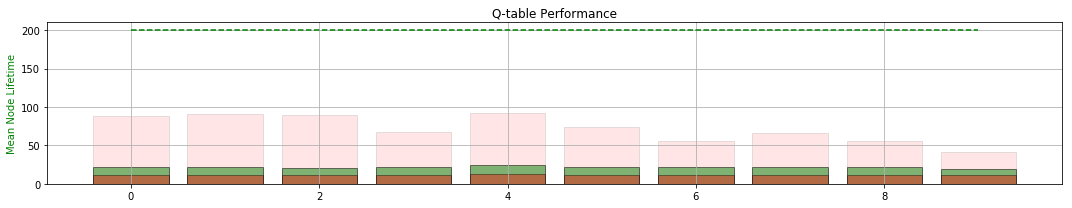

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 590.614	LOSS : 564.484	LOSS : 591.113	LOSS : 596.154	LOSS : 601.159	LOSS : 607.521	LOSS : 647.107	LOSS : 659.250	
Validating... MEAN TIME:  91.955
LOSS : 641.283	LOSS : 648.665	LOSS : 618.204	LOSS : 639.391	LOSS : 653.431	LOSS : 671.249	LOSS : 624.001	LOSS : 627.672	
Validating... MEAN TIME:  92.095
LOSS : 615.376	LOSS : 570.938	LOSS : 562.848	LOSS : 586.849	LOSS : 555.842	LOSS : 556.054	LOSS : 547.241	LOSS : 544.112	
Validating... MEAN TIME:  93.47
LOSS : 519.100	LOSS : 551.470	LOSS : 554.774	LOSS : 533.444	LOSS : 541.900	LOSS : 559.969	LOSS : 543.601	LOSS : 548.163	
Validating... MEAN TIME:  93.375
LOSS : 558.255	LOSS : 547.714	LOSS : 558.131	LOSS : 553.618	LOSS : 533.886	LOSS : 542.730	LOSS : 551.369	LOSS : 532.517	
Validating... MEAN TIME:  93.635
TRAINING TIME:0:00:42.240961


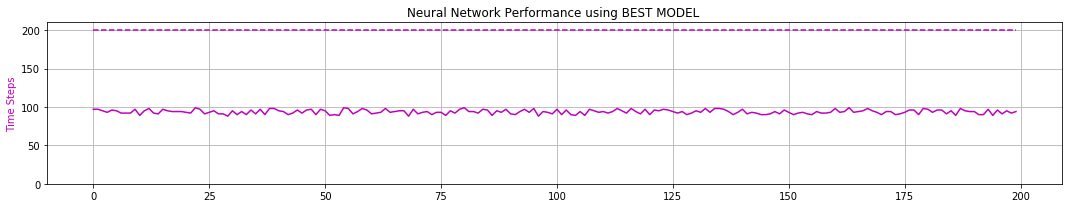

peak memory: 1426.34 MiB, increment: 1017.85 MiB
0 -max- [ 0.210  1.194  0.049  0.375]
0 -min- [-2.360 -3.314 -0.209 -1.673]

1 -max- [ 0.199  1.215  0.054  0.376]
1 -min- [-2.356 -3.243 -0.209 -1.730]

2 -max- [ 0.202  1.218  0.049  0.378]
2 -min- [-2.388 -3.283 -0.209 -1.675]

3 -max- [ 0.209  1.184  0.050  0.473]
3 -min- [-1.119 -2.340 -0.209 -1.680]

4 -max- [ 0.213  1.210  0.050  0.541]
4 -min- [-2.383 -3.270 -0.209 -1.695]

5 -max- [ 0.215  1.188  0.050  0.379]
5 -min- [-1.434 -2.602 -0.209 -1.683]

6 -max- [ 0.216  1.211  0.050  0.586]
6 -min- [-0.633 -1.842 -0.209 -1.678]

7 -max- [ 0.193  1.177  0.048  0.469]
7 -min- [-1.010 -2.223 -0.209 -1.768]

8 -max- [ 0.207  1.212  0.051  0.518]
8 -min- [-0.577 -1.850 -0.209 -1.735]

9 -max- [ 0.198  1.329  0.049  0.543]
9 -min- [-0.232 -1.331 -0.209 -1.974]

Quantization TIME:  0.01 minutes


ITERATION # 34
TOTAL EXPERIENCE GENERATED:   17969
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 91
TOTAL SERIAL TIMESTEPS:   1981285
TOTAL PARALLEL TI

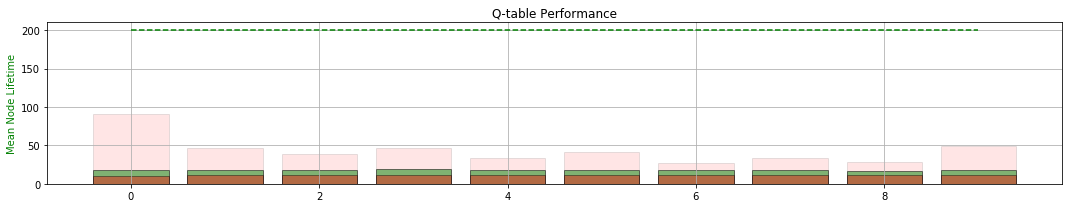

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 521.092	LOSS : 528.974	LOSS : 527.513	LOSS : 529.369	LOSS : 528.396	LOSS : 535.242	LOSS : 521.186	LOSS : 510.829	
Validating... MEAN TIME:  94.53
LOSS : 529.834	LOSS : 540.053	LOSS : 539.397	LOSS : 531.866	LOSS : 531.873	LOSS : 535.236	LOSS : 546.978	LOSS : 529.167	
Validating... MEAN TIME:  94.11
LOSS : 554.240	LOSS : 527.639	LOSS : 556.101	LOSS : 542.166	LOSS : 534.279	LOSS : 583.472	LOSS : 551.545	LOSS : 549.030	
Validating... MEAN TIME:  94.03
LOSS : 566.523	LOSS : 563.549	LOSS : 562.446	LOSS : 578.130	LOSS : 578.715	LOSS : 590.433	LOSS : 568.202	LOSS : 615.051	
Validating... MEAN TIME:  93.195
LOSS : 569.192	LOSS : 581.215	LOSS : 614.177	LOSS : 595.240	LOSS : 603.900	LOSS : 592.974	LOSS : 628.379	LOSS : 645.457	
Validating... MEAN TIME:  93.655
TRAINING TIME:0:00:43.822863


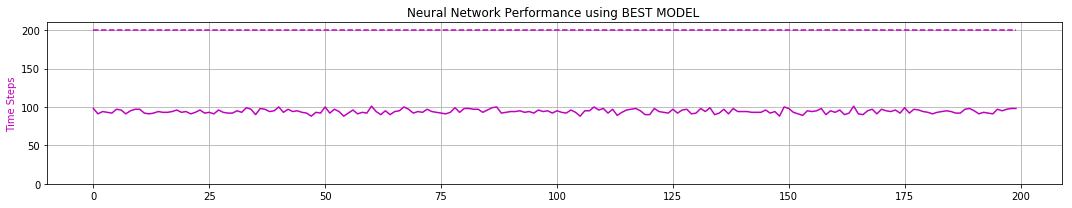

peak memory: 1445.09 MiB, increment: 998.20 MiB
0 -max- [ 0.199  1.215  0.048  0.589]
0 -min- [-2.369 -3.305 -0.209 -1.712]

1 -max- [ 0.202  1.357  0.049  0.358]
1 -min- [-0.336 -1.515 -0.209 -1.977]

2 -max- [ 0.209  1.184  0.050  0.355]
2 -min- [-0.194 -1.305 -0.209 -1.680]

3 -max- [ 0.212  1.210  0.050  0.373]
3 -min- [-0.479 -1.676 -0.209 -1.767]

4 -max- [ 0.215  1.017  0.050  0.372]
4 -min- [-0.094 -1.090 -0.209 -1.536]

5 -max- [ 0.216  1.211  0.050  0.369]
5 -min- [-0.240 -1.336 -0.209 -1.678]

6 -max- [ 0.193  1.177  0.048  0.353]
6 -min- [-0.047 -0.789 -0.209 -1.759]

7 -max- [ 0.202  1.138  0.050  0.498]
7 -min- [-0.068 -0.936 -0.209 -1.675]

8 -max- [ 0.198  1.329  0.049  0.312]
8 -min- [-0.050 -0.952 -0.209 -1.974]

9 -max- [ 0.212  1.216  0.050  0.376]
9 -min- [-0.469 -1.663 -0.209 -1.676]

Quantization TIME:  0.01 minutes


ITERATION # 35
TOTAL EXPERIENCE GENERATED:   27031
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 93
TOTAL SERIAL TIMESTEPS:   2008316
TOTAL PARALLEL TIM

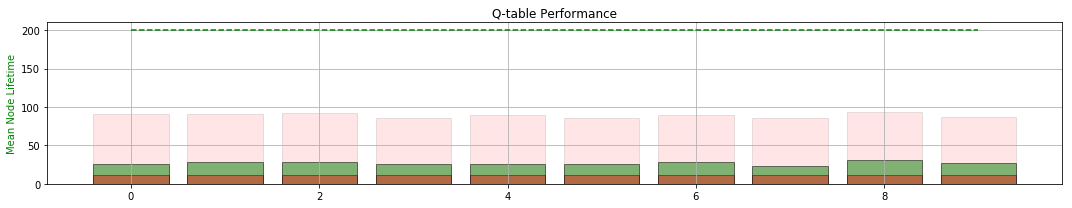

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 631.660	LOSS : 633.703	LOSS : 622.476	LOSS : 625.911	LOSS : 631.069	LOSS : 654.958	LOSS : 643.020	LOSS : 617.142	
Validating... MEAN TIME:  93.015
LOSS : 638.950	LOSS : 643.020	LOSS : 619.160	LOSS : 612.002	LOSS : 614.905	LOSS : 658.133	LOSS : 653.072	LOSS : 646.500	
Validating... MEAN TIME:  93.205
LOSS : 624.636	LOSS : 619.673	LOSS : 642.724	LOSS : 628.218	LOSS : 642.530	LOSS : 654.711	LOSS : 670.665	LOSS : 667.590	
Validating... MEAN TIME:  92.81
LOSS : 610.304	LOSS : 622.891	LOSS : 600.290	LOSS : 602.718	LOSS : 598.358	LOSS : 572.445	LOSS : 549.863	LOSS : 551.211	
Validating... MEAN TIME:  94.76
LOSS : 532.537	LOSS : 534.966	LOSS : 533.777	LOSS : 571.489	LOSS : 578.846	LOSS : 574.253	LOSS : 571.342	LOSS : 584.008	
Validating... MEAN TIME:  94.005
TRAINING TIME:0:00:42.107507


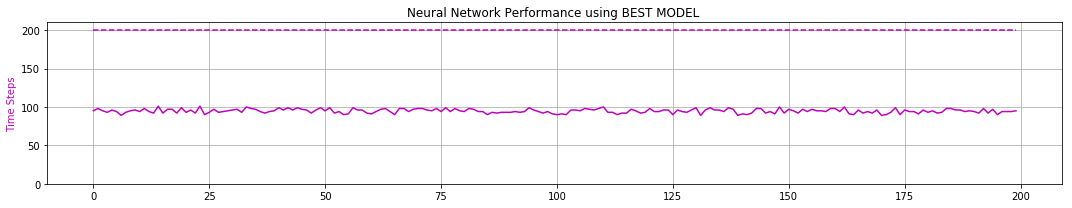

peak memory: 1445.22 MiB, increment: 1017.61 MiB
0 -max- [ 0.194  1.218  0.049  0.458]
0 -min- [-2.392 -3.329 -0.209 -1.795]

1 -max- [ 0.197  1.184  0.050  0.527]
1 -min- [-2.379 -3.424 -0.209 -1.680]

2 -max- [ 0.204  1.210  0.050  0.492]
2 -min- [-2.376 -3.425 -0.209 -1.682]

3 -max- [ 0.215  1.175  0.050  0.376]
3 -min- [-2.355 -3.330 -0.209 -1.769]

4 -max- [ 0.216  1.211  0.050  0.514]
4 -min- [-2.368 -3.250 -0.209 -1.678]

5 -max- [ 0.193  1.177  0.048  0.577]
5 -min- [-2.224 -3.116 -0.209 -1.680]

6 -max- [ 0.200  1.212  0.054  0.569]
6 -min- [-2.385 -3.306 -0.209 -1.675]

7 -max- [ 0.198  1.156  0.049  0.475]
7 -min- [-2.391 -3.298 -0.209 -1.678]

8 -max- [ 0.212  1.216  0.050  0.479]
8 -min- [-2.397 -3.321 -0.209 -1.724]

9 -max- [ 0.170  1.159  0.049  0.496]
9 -min- [-2.363 -3.310 -0.209 -1.681]

Quantization TIME:  0.02 minutes


ITERATION # 36
TOTAL EXPERIENCE GENERATED:   26977
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 92
TOTAL SERIAL TIMESTEPS:   2035293
TOTAL PARALLEL TI

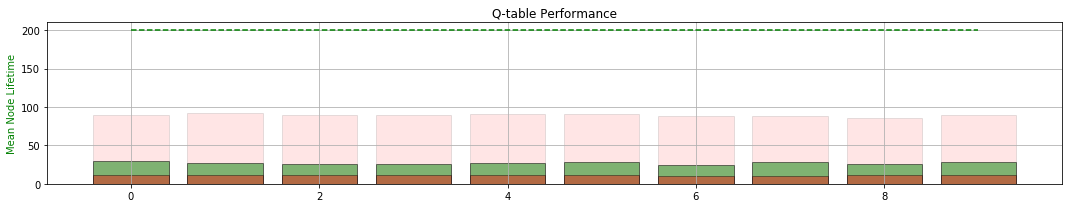

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 631.489	LOSS : 593.473	LOSS : 606.149	LOSS : 681.471	LOSS : 641.038	LOSS : 665.103	LOSS : 645.251	LOSS : 665.434	
Validating... MEAN TIME:  93.185
LOSS : 666.009	LOSS : 672.483	LOSS : 662.278	LOSS : 672.351	LOSS : 656.905	LOSS : 628.087	LOSS : 638.412	LOSS : 630.726	
Validating... MEAN TIME:  93.655
LOSS : 616.078	LOSS : 578.432	LOSS : 601.644	LOSS : 569.789	LOSS : 589.373	LOSS : 545.066	LOSS : 559.434	LOSS : 576.413	
Validating... MEAN TIME:  94.22
LOSS : 545.509	LOSS : 581.279	LOSS : 592.636	LOSS : 592.814	LOSS : 612.401	LOSS : 614.527	LOSS : 627.349	LOSS : 667.869	
Validating... MEAN TIME:  93.295
LOSS : 700.929	LOSS : 645.518	LOSS : 693.769	LOSS : 712.667	LOSS : 707.479	LOSS : 665.270	LOSS : 618.082	LOSS : 638.980	
Validating... MEAN TIME:  93.99
TRAINING TIME:0:00:41.578934


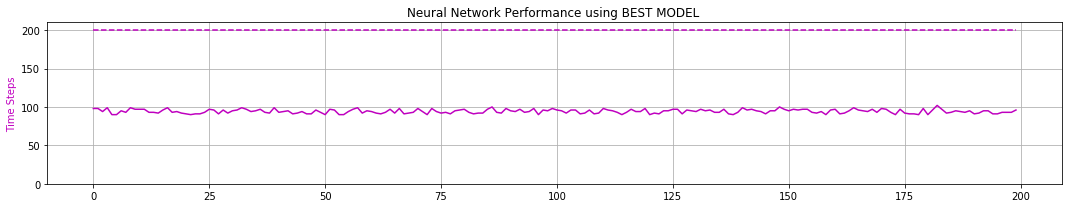

peak memory: 1457.69 MiB, increment: 1055.31 MiB
0 -max- [ 0.197  1.188  0.050  0.594]
0 -min- [-2.354 -3.242 -0.209 -1.779]

1 -max- [ 0.204  1.210  0.050  0.467]
1 -min- [-2.353 -3.259 -0.209 -1.790]

2 -max- [ 0.215  1.144  0.050  0.591]
2 -min- [-2.354 -3.279 -0.209 -1.668]

3 -max- [ 0.216  1.211  0.050  0.514]
3 -min- [-2.211 -3.140 -0.209 -1.786]

4 -max- [ 0.197  1.168  0.048  0.376]
4 -min- [-2.339 -3.280 -0.209 -1.680]

5 -max- [ 0.200  1.212  0.054  0.563]
5 -min- [-2.378 -3.306 -0.209 -1.716]

6 -max- [ 0.198  1.215  0.049  0.453]
6 -min- [-2.391 -3.257 -0.209 -1.757]

7 -max- [ 0.201  1.216  0.050  0.562]
7 -min- [-2.358 -3.326 -0.209 -1.676]

8 -max- [ 0.170  1.159  0.049  0.517]
8 -min- [-2.348 -3.311 -0.209 -1.681]

9 -max- [ 0.217  1.171  0.049  0.499]
9 -min- [-2.353 -3.279 -0.209 -1.668]

Quantization TIME:  0.02 minutes


ITERATION # 37
TOTAL EXPERIENCE GENERATED:   26131
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 88
TOTAL SERIAL TIMESTEPS:   2061424
TOTAL PARALLEL TI

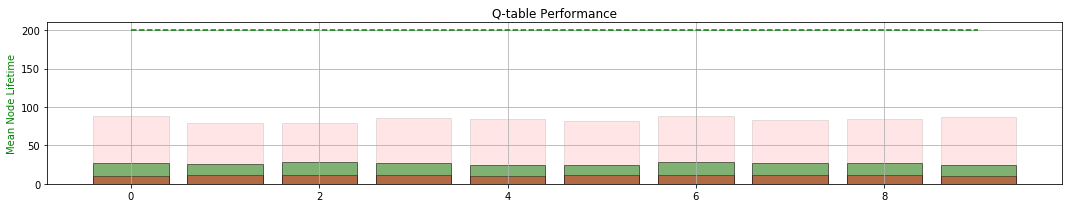

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 631.932	LOSS : 645.985	LOSS : 619.458	LOSS : 603.374	LOSS : 572.901	LOSS : 591.757	LOSS : 575.253	LOSS : 557.073	
Validating... MEAN TIME:  93.865
LOSS : 596.331	LOSS : 567.590	LOSS : 587.982	LOSS : 572.763	LOSS : 619.175	LOSS : 632.139	LOSS : 629.896	LOSS : 629.069	
Validating... MEAN TIME:  94.315
LOSS : 637.861	LOSS : 608.673	LOSS : 613.514	LOSS : 610.862	LOSS : 612.857	LOSS : 631.381	LOSS : 600.505	LOSS : 634.617	
Validating... MEAN TIME:  93.765
LOSS : 640.853	LOSS : 595.978	LOSS : 605.575	LOSS : 583.211	LOSS : 596.632	LOSS : 613.572	LOSS : 601.731	LOSS : 626.364	
Validating... MEAN TIME:  94.625
LOSS : 603.916	LOSS : 636.568	LOSS : 648.146	LOSS : 638.033	LOSS : 643.584	LOSS : 621.360	LOSS : 634.016	LOSS : 640.640	
Validating... MEAN TIME:  94.13
TRAINING TIME:0:00:42.505254


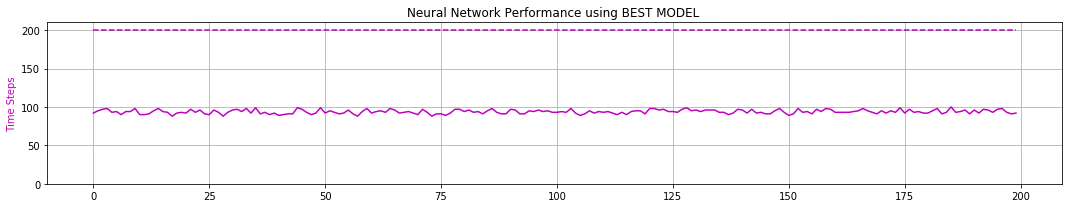

peak memory: 1430.22 MiB, increment: 988.06 MiB
0 -max- [ 0.204  1.210  0.050  0.558]
0 -min- [-2.118 -3.084 -0.209 -1.694]

1 -max- [ 0.222  1.175  0.050  0.528]
1 -min- [-1.719 -2.783 -0.209 -1.769]

2 -max- [ 0.216  1.211  0.050  0.494]
2 -min- [-1.843 -2.882 -0.209 -1.691]

3 -max- [ 0.193  1.177  0.048  0.564]
3 -min- [-2.202 -3.152 -0.209 -1.767]

4 -max- [ 0.200  1.180  0.050  0.555]
4 -min- [-2.008 -2.939 -0.209 -1.815]

5 -max- [ 0.195  1.181  0.049  0.560]
5 -min- [-2.119 -2.937 -0.209 -1.678]

6 -max- [ 0.210  1.216  0.054  0.536]
6 -min- [-2.117 -3.121 -0.209 -1.738]

7 -max- [ 0.172  1.159  0.049  0.524]
7 -min- [-2.115 -3.066 -0.209 -1.681]

8 -max- [ 0.217  1.171  0.049  0.376]
8 -min- [-2.088 -3.097 -0.209 -1.668]

9 -max- [ 0.218  1.207  0.047  0.520]
9 -min- [-2.084 -3.095 -0.209 -1.805]

Quantization TIME:  0.01 minutes


ITERATION # 38
TOTAL EXPERIENCE GENERATED:   26149
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 84
TOTAL SERIAL TIMESTEPS:   2087573
TOTAL PARALLEL TIM

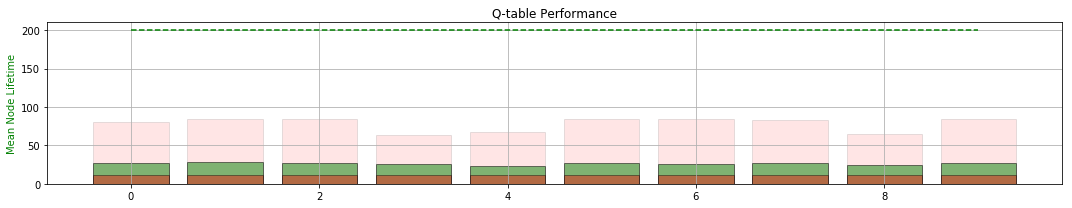

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 627.161	LOSS : 623.818	LOSS : 673.338	LOSS : 663.354	LOSS : 652.842	LOSS : 622.007	LOSS : 658.192	LOSS : 655.768	
Validating... MEAN TIME:  94.025
LOSS : 657.263	LOSS : 643.615	LOSS : 661.054	LOSS : 628.300	LOSS : 642.582	LOSS : 641.911	LOSS : 604.069	LOSS : 643.617	
Validating... MEAN TIME:  93.64
LOSS : 619.965	LOSS : 653.028	LOSS : 624.247	LOSS : 620.907	LOSS : 651.413	LOSS : 610.553	LOSS : 641.719	LOSS : 654.843	
Validating... MEAN TIME:  93.39
LOSS : 644.292	LOSS : 642.305	LOSS : 645.045	LOSS : 648.813	LOSS : 636.902	LOSS : 634.118	LOSS : 681.786	LOSS : 657.452	
Validating... MEAN TIME:  93.655
LOSS : 641.792	LOSS : 671.448	LOSS : 656.022	LOSS : 624.530	LOSS : 661.082	LOSS : 653.428	LOSS : 638.949	LOSS : 650.355	
Validating... MEAN TIME:  93.795
TRAINING TIME:0:00:43.408634


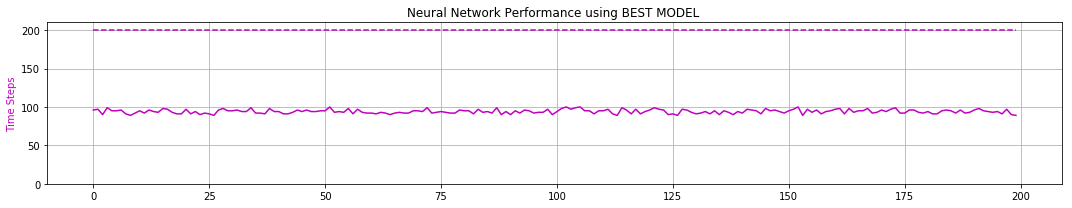

peak memory: 1447.09 MiB, increment: 1033.98 MiB
0 -max- [ 0.222  1.213  0.050  0.566]
0 -min- [-1.911 -2.965 -0.209 -1.883]

1 -max- [ 0.216  1.211  0.050  0.390]
1 -min- [-1.991 -2.951 -0.209 -1.691]

2 -max- [ 0.191  1.177  0.048  0.568]
2 -min- [-2.027 -3.065 -0.209 -1.680]

3 -max- [ 0.200  1.121  0.050  0.568]
3 -min- [-1.005 -2.210 -0.209 -1.672]

4 -max- [ 0.202  1.188  0.049  0.376]
4 -min- [-1.374 -2.520 -0.209 -1.769]

5 -max- [ 0.204  1.216  0.058  0.377]
5 -min- [-1.997 -2.963 -0.209 -1.755]

6 -max- [ 0.172  1.159  0.049  0.526]
6 -min- [-2.117 -2.953 -0.209 -1.681]

7 -max- [ 0.217  1.171  0.049  0.376]
7 -min- [-1.968 -2.916 -0.209 -1.668]

8 -max- [ 0.218  1.399  0.047  0.598]
8 -min- [-1.235 -2.421 -0.209 -1.984]

9 -max- [ 0.208  1.209  0.051  0.568]
9 -min- [-2.046 -2.938 -0.209 -1.793]

Quantization TIME:  0.01 minutes


ITERATION # 39
TOTAL EXPERIENCE GENERATED:   27901
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 89
TOTAL SERIAL TIMESTEPS:   2115474
TOTAL PARALLEL TI

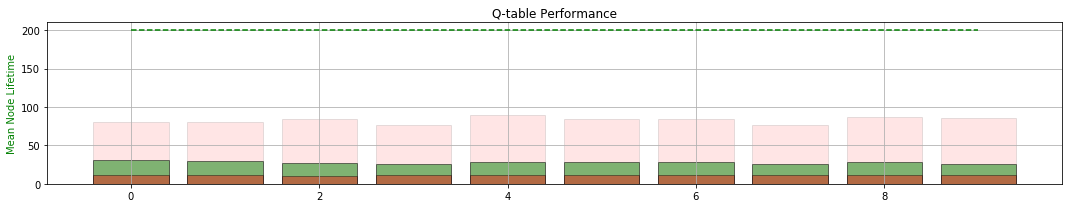

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 654.601	LOSS : 635.603	LOSS : 692.234	LOSS : 682.652	LOSS : 656.459	LOSS : 686.924	LOSS : 628.950	LOSS : 638.565	
Validating... MEAN TIME:  93.61
LOSS : 609.609	LOSS : 629.447	LOSS : 652.339	LOSS : 630.775	LOSS : 640.485	LOSS : 675.464	LOSS : 644.732	LOSS : 672.311	
Validating... MEAN TIME:  93.41
LOSS : 690.932	LOSS : 685.619	LOSS : 678.610	LOSS : 664.692	LOSS : 662.472	LOSS : 650.896	LOSS : 656.331	LOSS : 644.527	
Validating... MEAN TIME:  93.645
LOSS : 629.416	LOSS : 670.350	LOSS : 661.518	LOSS : 649.544	LOSS : 642.542	LOSS : 672.378	LOSS : 664.330	LOSS : 663.105	
Validating... MEAN TIME:  93.735
LOSS : 656.333	LOSS : 679.851	LOSS : 694.357	LOSS : 664.813	LOSS : 667.908	LOSS : 662.017	LOSS : 651.561	LOSS : 652.548	
Validating... MEAN TIME:  93.6
TRAINING TIME:0:00:41.083031


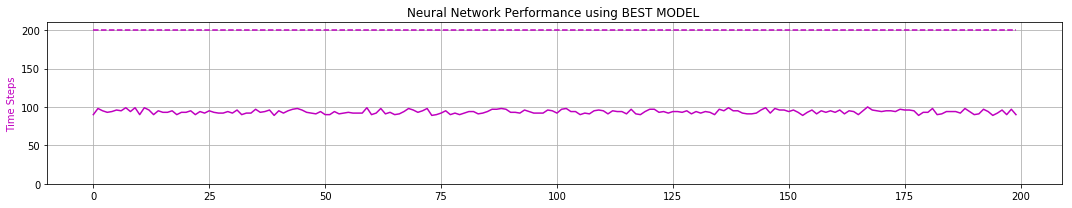

peak memory: 1433.22 MiB, increment: 981.04 MiB
0 -max- [ 0.216  1.211  0.050  0.595]
0 -min- [-1.886 -2.890 -0.209 -1.691]

1 -max- [ 0.190  1.177  0.048  0.586]
1 -min- [-1.974 -2.936 -0.209 -1.680]

2 -max- [ 0.200  1.213  0.050  0.496]
2 -min- [-1.999 -3.054 -0.209 -1.725]

3 -max- [ 0.195  1.156  0.049  0.568]
3 -min- [-1.537 -2.722 -0.209 -1.678]

4 -max- [ 0.204  1.216  0.050  0.486]
4 -min- [-2.178 -3.126 -0.209 -1.692]

5 -max- [ 0.172  1.164  0.049  0.489]
5 -min- [-2.117 -2.953 -0.209 -1.681]

6 -max- [ 0.217  1.171  0.049  0.376]
6 -min- [-2.191 -3.107 -0.209 -1.662]

7 -max- [ 0.224  1.209  0.054  0.523]
7 -min- [-1.687 -2.762 -0.209 -1.757]

8 -max- [ 0.208  1.209  0.051  0.550]
8 -min- [-2.267 -3.141 -0.209 -1.779]

9 -max- [ 0.200  1.137  0.047  0.483]
9 -min- [-2.126 -3.103 -0.209 -1.675]

Quantization TIME:  0.01 minutes


ITERATION # 40
TOTAL EXPERIENCE GENERATED:   27242
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 83
TOTAL SERIAL TIMESTEPS:   2142716
TOTAL PARALLEL TIM

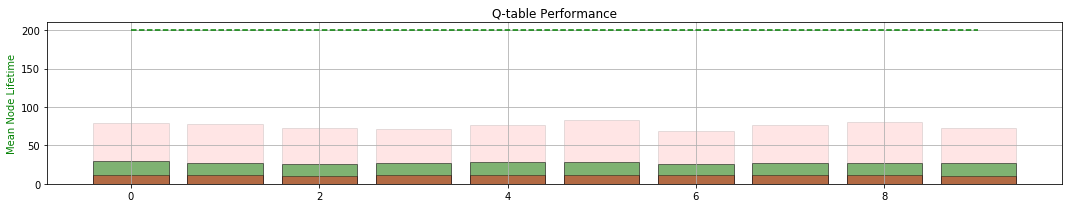

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 653.040	LOSS : 653.057	LOSS : 646.659	LOSS : 639.457	LOSS : 654.437	LOSS : 677.182	LOSS : 687.506	LOSS : 695.967	
Validating... MEAN TIME:  93.28
LOSS : 692.154	LOSS : 684.968	LOSS : 664.737	LOSS : 663.551	LOSS : 673.461	LOSS : 700.107	LOSS : 692.190	LOSS : 708.235	
Validating... MEAN TIME:  93.79
LOSS : 717.090	LOSS : 735.226	LOSS : 635.083	LOSS : 687.000	LOSS : 689.572	LOSS : 692.260	LOSS : 676.181	LOSS : 686.435	
Validating... MEAN TIME:  93.535
LOSS : 668.708	LOSS : 680.102	LOSS : 690.669	LOSS : 665.344	LOSS : 656.938	LOSS : 715.231	LOSS : 646.253	LOSS : 674.027	
Validating... MEAN TIME:  93.385
LOSS : 675.815	LOSS : 669.616	LOSS : 670.001	LOSS : 692.290	LOSS : 682.756	LOSS : 675.085	LOSS : 679.647	LOSS : 657.915	
Validating... MEAN TIME:  93.345
TRAINING TIME:0:00:41.927429


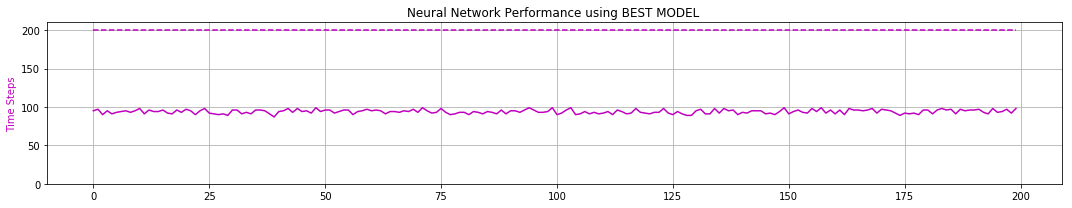

peak memory: 1469.28 MiB, increment: 978.17 MiB
0 -max- [ 0.191  1.177  0.048  0.556]
0 -min- [-1.740 -2.884 -0.209 -1.680]

1 -max- [ 0.200  1.138  0.050  0.571]
1 -min- [-1.666 -2.784 -0.209 -1.675]

2 -max- [ 0.195  1.156  0.049  0.376]
2 -min- [-1.337 -2.568 -0.209 -1.713]

3 -max- [ 0.204  1.216  0.050  0.591]
3 -min- [-1.354 -2.543 -0.209 -1.676]

4 -max- [ 0.177  1.191  0.049  0.481]
4 -min- [-1.651 -2.750 -0.209 -1.754]

5 -max- [ 0.205  1.171  0.049  0.377]
5 -min- [-1.776 -2.885 -0.209 -1.668]

6 -max- [ 0.218  1.210  0.047  0.599]
6 -min- [-1.410 -2.554 -0.209 -1.788]

7 -max- [ 0.208  1.209  0.051  0.600]
7 -min- [-1.634 -2.774 -0.209 -1.695]

8 -max- [ 0.200  1.137  0.047  0.560]
8 -min- [-1.857 -2.949 -0.209 -1.776]

9 -max- [ 0.211  1.354  0.050  0.586]
9 -min- [-1.436 -2.606 -0.209 -2.099]

Quantization TIME:  0.02 minutes


ITERATION # 41
TOTAL EXPERIENCE GENERATED:   27445
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 84
TOTAL SERIAL TIMESTEPS:   2170161
TOTAL PARALLEL TIM

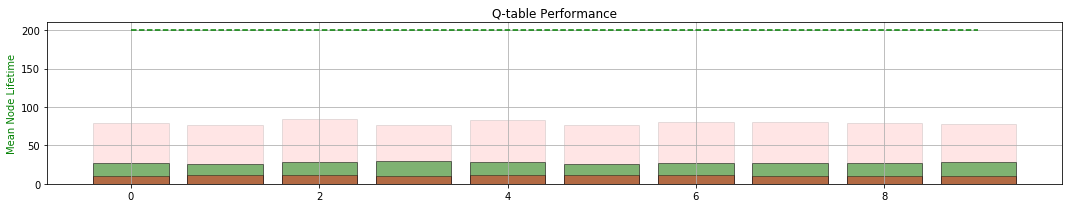

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 737.349	LOSS : 708.353	LOSS : 821.297	LOSS : 863.449	LOSS : 787.751	LOSS : 789.858	LOSS : 758.813	LOSS : 735.143	
Validating... MEAN TIME:  93.005
LOSS : 723.756	LOSS : 690.411	LOSS : 690.668	LOSS : 690.337	LOSS : 697.360	LOSS : 680.595	LOSS : 697.695	LOSS : 731.846	
Validating... MEAN TIME:  92.99
LOSS : 747.704	LOSS : 736.762	LOSS : 698.191	LOSS : 719.439	LOSS : 705.819	LOSS : 747.651	LOSS : 719.824	LOSS : 705.192	
Validating... MEAN TIME:  92.77
LOSS : 684.172	LOSS : 690.396	LOSS : 684.911	LOSS : 702.460	LOSS : 692.554	LOSS : 725.932	LOSS : 735.512	LOSS : 724.380	
Validating... MEAN TIME:  93.125
LOSS : 732.088	LOSS : 722.615	LOSS : 750.058	LOSS : 729.392	LOSS : 726.325	LOSS : 725.492	LOSS : 739.515	LOSS : 726.775	
Validating... MEAN TIME:  93.16
TRAINING TIME:0:00:41.089878


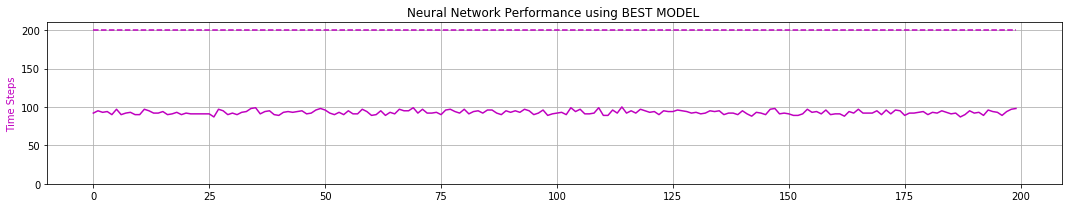

peak memory: 1448.80 MiB, increment: 1016.98 MiB
0 -max- [ 0.200  1.213  0.050  0.496]
0 -min- [-1.886 -2.909 -0.209 -1.725]

1 -max- [ 0.195  1.156  0.049  0.568]
1 -min- [-1.537 -2.722 -0.209 -1.678]

2 -max- [ 0.204  1.216  0.050  0.560]
2 -min- [-1.873 -2.938 -0.209 -1.676]

3 -max- [ 0.172  1.159  0.049  0.599]
3 -min- [-1.661 -2.772 -0.209 -1.681]

4 -max- [ 0.217  1.171  0.049  0.509]
4 -min- [-1.776 -2.885 -0.209 -1.668]

5 -max- [ 0.224  1.209  0.054  0.523]
5 -min- [-1.687 -2.762 -0.209 -1.757]

6 -max- [ 0.210  1.209  0.057  0.546]
6 -min- [-1.815 -2.907 -0.209 -1.779]

7 -max- [ 0.200  1.184  0.047  0.496]
7 -min- [-1.809 -2.932 -0.209 -1.677]

8 -max- [ 0.211  1.217  0.050  0.576]
8 -min- [-1.624 -2.747 -0.209 -1.772]

9 -max- [ 0.187  1.200  0.050  0.376]
9 -min- [-1.640 -2.776 -0.209 -1.879]

Quantization TIME:  0.02 minutes


ITERATION # 42
TOTAL EXPERIENCE GENERATED:   27479
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 86
TOTAL SERIAL TIMESTEPS:   2197640
TOTAL PARALLEL TI

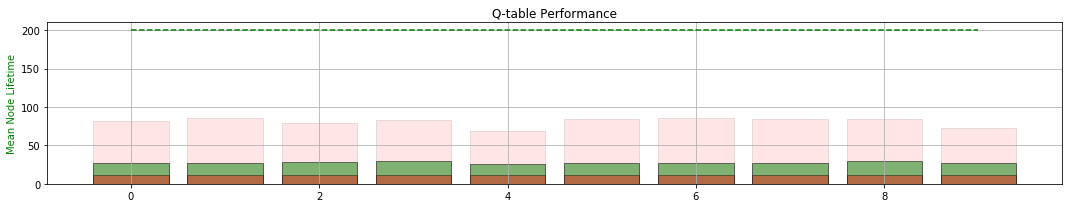

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 699.063	LOSS : 730.553	LOSS : 707.462	LOSS : 722.684	LOSS : 700.888	LOSS : 710.962	LOSS : 685.780	LOSS : 693.311	
Validating... MEAN TIME:  93.22
LOSS : 708.452	LOSS : 798.136	LOSS : 780.784	LOSS : 814.635	LOSS : 832.130	LOSS : 851.344	LOSS : 792.577	LOSS : 731.422	
Validating... MEAN TIME:  92.815
LOSS : 718.096	LOSS : 710.258	LOSS : 706.331	LOSS : 698.345	LOSS : 741.925	LOSS : 755.519	LOSS : 845.121	LOSS : 834.326	
Validating... MEAN TIME:  92.59
LOSS : 948.749	LOSS : 1031.013	LOSS : 1105.116	LOSS : 1178.292	LOSS : 1209.887	LOSS : 1234.756	LOSS : 1141.146	LOSS : 1144.734	
Validating... MEAN TIME:  91.745
LOSS : 1172.379	LOSS : 1226.362	LOSS : 1185.325	LOSS : 1208.569	LOSS : 1133.104	LOSS : 1143.619	LOSS : 1168.645	LOSS : 1156.645	
Validating... MEAN TIME:  91.325
TRAINING TIME:0:00:41.898275


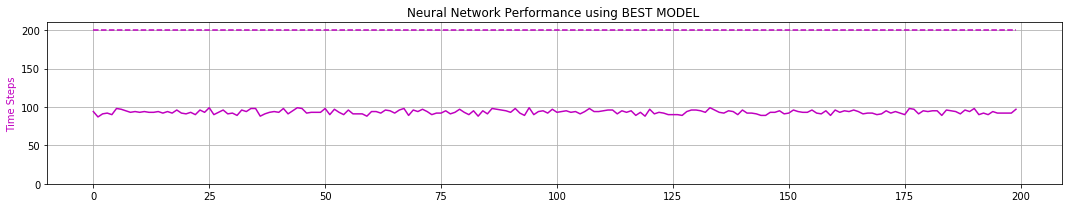

peak memory: 1429.41 MiB, increment: 977.92 MiB
0 -max- [ 0.195  1.156  0.049  0.565]
0 -min- [-1.859 -2.935 -0.209 -1.713]

1 -max- [ 0.204  1.216  0.050  0.591]
1 -min- [-1.987 -2.939 -0.209 -1.738]

2 -max- [ 0.177  1.355  0.049  0.509]
2 -min- [-1.925 -2.936 -0.209 -1.989]

3 -max- [ 0.217  1.171  0.049  0.376]
3 -min- [-1.900 -2.926 -0.209 -1.668]

4 -max- [ 0.218  1.210  0.047  0.599]
4 -min- [-1.410 -2.554 -0.209 -1.788]

5 -max- [ 0.208  1.209  0.051  0.583]
5 -min- [-2.046 -2.940 -0.209 -1.664]

6 -max- [ 0.200  1.213  0.047  0.523]
6 -min- [-2.090 -2.943 -0.209 -1.820]

7 -max- [ 0.211  1.217  0.050  0.586]
7 -min- [-1.960 -2.967 -0.209 -1.742]

8 -max- [ 0.187  1.207  0.050  0.515]
8 -min- [-1.975 -2.956 -0.209 -1.778]

9 -max- [ 0.194  1.214  0.050  0.696]
9 -min- [-1.672 -2.755 -0.209 -1.762]

Quantization TIME:  0.02 minutes


ITERATION # 43
TOTAL EXPERIENCE GENERATED:   27018
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 83
TOTAL SERIAL TIMESTEPS:   2224658
TOTAL PARALLEL TIME

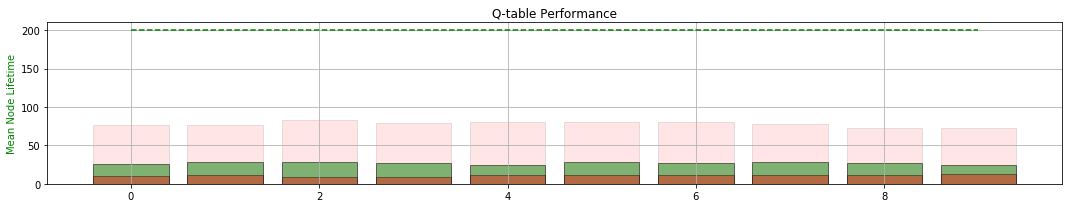

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 1138.679	LOSS : 1077.630	LOSS : 1056.829	LOSS : 1038.679	LOSS : 1065.788	LOSS : 1081.804	LOSS : 1072.875	LOSS : 1118.128	
Validating... MEAN TIME:  91.635
LOSS : 1183.116	LOSS : 1075.309	LOSS : 1120.012	LOSS : 1106.822	LOSS : 1037.880	LOSS : 1023.975	LOSS : 1038.311	LOSS : 981.023	
Validating... MEAN TIME:  91.62
LOSS : 1009.131	LOSS : 1002.401	LOSS : 1018.441	LOSS : 976.880	LOSS : 1016.776	LOSS : 936.850	LOSS : 929.604	LOSS : 940.878	
Validating... MEAN TIME:  91.525
LOSS : 909.525	LOSS : 928.334	LOSS : 945.691	LOSS : 909.754	LOSS : 893.066	LOSS : 844.506	LOSS : 917.730	LOSS : 945.315	
Validating... MEAN TIME:  91.64
LOSS : 895.700	LOSS : 886.567	LOSS : 900.644	LOSS : 940.271	LOSS : 895.492	LOSS : 924.599	LOSS : 968.203	LOSS : 967.148	
Validating... MEAN TIME:  91.57
TRAINING TIME:0:00:41.496034


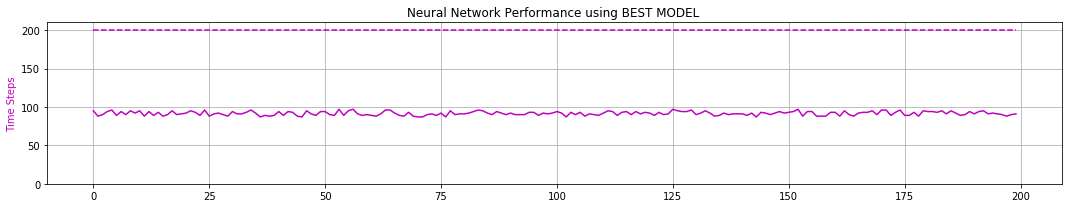

peak memory: 1468.48 MiB, increment: 977.80 MiB
0 -max- [ 0.204  1.216  0.050  0.556]
0 -min- [-1.708 -2.780 -0.209 -1.738]

1 -max- [ 0.178  1.159  0.049  0.585]
1 -min- [-1.661 -2.772 -0.209 -1.681]

2 -max- [ 0.217  1.171  0.049  0.589]
2 -min- [-1.776 -2.885 -0.209 -1.732]

3 -max- [ 0.218  1.203  0.047  0.544]
3 -min- [-1.791 -2.891 -0.209 -1.678]

4 -max- [ 0.208  1.220  0.051  0.583]
4 -min- [-1.815 -2.907 -0.209 -1.811]

5 -max- [ 0.200  1.137  0.047  0.596]
5 -min- [-1.857 -2.949 -0.209 -1.675]

6 -max- [ 0.211  1.217  0.050  0.532]
6 -min- [-1.744 -2.791 -0.209 -1.814]

7 -max- [ 0.182  1.200  0.050  0.551]
7 -min- [-1.695 -2.776 -0.209 -1.679]

8 -max- [ 0.193  1.209  0.050  0.525]
8 -min- [-1.672 -2.755 -0.209 -1.679]

9 -max- [ 0.202  1.218  0.049  0.535]
9 -min- [-1.634 -2.760 -0.209 -1.691]

Quantization TIME:  0.02 minutes


ITERATION # 44
TOTAL EXPERIENCE GENERATED:   17159
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 38
TOTAL SERIAL TIMESTEPS:   2241817
TOTAL PARALLEL TIM

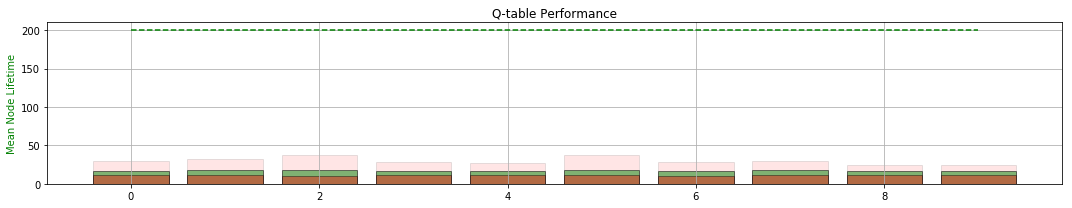

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 949.202	LOSS : 937.389	LOSS : 942.348	LOSS : 915.601	LOSS : 931.110	LOSS : 917.466	LOSS : 882.431	LOSS : 914.354	
Validating... MEAN TIME:  91.435
LOSS : 864.860	LOSS : 841.029	LOSS : 864.369	LOSS : 825.657	LOSS : 836.391	LOSS : 849.890	LOSS : 887.720	LOSS : 877.517	
Validating... MEAN TIME:  91.99
LOSS : 833.578	LOSS : 852.491	LOSS : 855.261	LOSS : 863.515	LOSS : 868.775	LOSS : 884.422	LOSS : 840.503	LOSS : 844.706	
Validating... MEAN TIME:  91.6
LOSS : 919.853	LOSS : 837.493	LOSS : 842.505	LOSS : 885.932	LOSS : 845.384	LOSS : 876.177	LOSS : 875.469	LOSS : 888.706	
Validating... MEAN TIME:  91.655
LOSS : 876.637	LOSS : 876.920	LOSS : 849.845	LOSS : 887.135	LOSS : 873.090	LOSS : 915.142	LOSS : 930.319	LOSS : 877.620	
Validating... MEAN TIME:  92.11
TRAINING TIME:0:00:43.004459


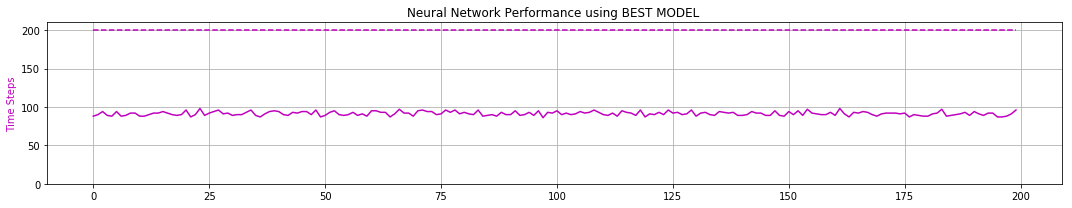

peak memory: 1478.24 MiB, increment: 977.20 MiB
0 -max- [ 0.178  1.159  0.049  0.351]
0 -min- [-0.050 -0.776 -0.209 -1.762]

1 -max- [ 0.217  1.182  0.049  0.366]
1 -min- [-0.050 -0.970 -0.209 -1.831]

2 -max- [ 0.218  1.202  0.047  0.372]
2 -min- [-0.133 -1.153 -0.209 -1.674]

3 -max- [ 0.208  1.214  0.051  0.363]
3 -min- [-0.050 -0.884 -0.209 -1.664]

4 -max- [ 0.200  1.137  0.047  0.453]
4 -min- [-0.049 -0.791 -0.209 -1.675]

5 -max- [ 0.211  1.217  0.050  0.369]
5 -min- [-0.164 -1.140 -0.209 -1.799]

6 -max- [ 0.187  1.200  0.058  0.350]
6 -min- [-0.050 -0.783 -0.209 -1.676]

7 -max- [ 0.193  1.209  0.050  0.375]
7 -min- [-0.049 -0.779 -0.209 -1.679]

8 -max- [ 0.202  1.218  0.049  0.343]
8 -min- [-0.050 -0.769 -0.209 -1.687]

9 -max- [ 0.215  1.218  0.050  0.286]
9 -min- [-0.049 -0.715 -0.209 -1.679]

Quantization TIME:  0.02 minutes


ITERATION # 45
TOTAL EXPERIENCE GENERATED:   19003
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 51
TOTAL SERIAL TIMESTEPS:   2260820
TOTAL PARALLEL TIM

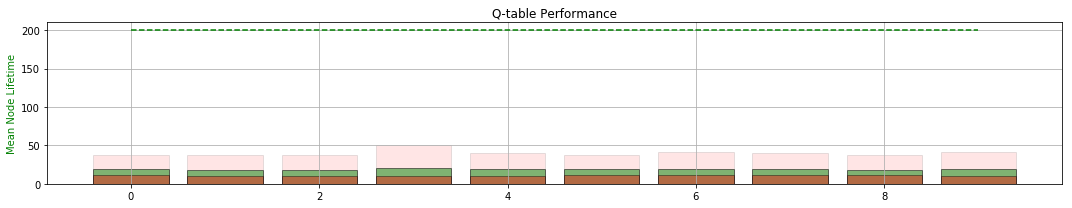

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 843.814	LOSS : 903.480	LOSS : 861.539	LOSS : 915.504	LOSS : 917.792	LOSS : 869.111	LOSS : 880.510	LOSS : 913.181	
Validating... MEAN TIME:  91.685
LOSS : 870.039	LOSS : 906.451	LOSS : 926.641	LOSS : 958.086	LOSS : 897.091	LOSS : 951.508	LOSS : 877.961	LOSS : 915.051	
Validating... MEAN TIME:  91.82
LOSS : 895.412	LOSS : 899.125	LOSS : 925.700	LOSS : 886.384	LOSS : 941.609	LOSS : 909.224	LOSS : 980.383	LOSS : 922.687	
Validating... MEAN TIME:  91.81
LOSS : 906.551	LOSS : 886.972	LOSS : 960.625	LOSS : 900.470	LOSS : 904.813	LOSS : 939.312	LOSS : 907.667	LOSS : 868.121	
Validating... MEAN TIME:  91.33
LOSS : 913.661	LOSS : 899.760	LOSS : 847.275	LOSS : 961.532	LOSS : 923.736	LOSS : 931.922	LOSS : 924.621	LOSS : 938.961	
Validating... MEAN TIME:  91.705
TRAINING TIME:0:00:42.216845


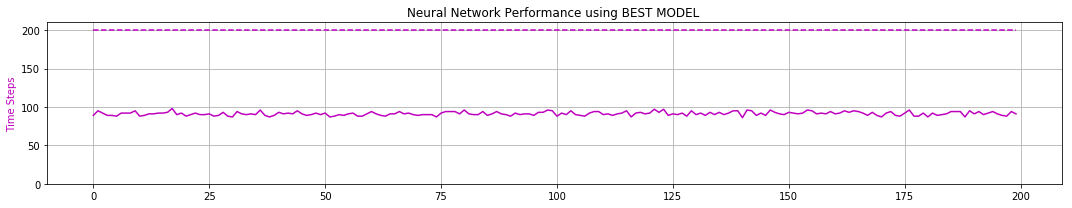

peak memory: 1460.45 MiB, increment: 1053.66 MiB
0 -max- [ 0.224  1.172  0.049  0.376]
0 -min- [-0.143 -1.150 -0.209 -1.719]

1 -max- [ 0.220  1.203  0.047  0.507]
1 -min- [-0.178 -1.241 -0.209 -1.795]

2 -max- [ 0.217  1.352  0.051  0.580]
2 -min- [-0.225 -1.345 -0.209 -2.037]

3 -max- [ 0.199  1.137  0.047  0.375]
3 -min- [-0.372 -1.602 -0.209 -1.670]

4 -max- [ 0.207  1.219  0.050  0.375]
4 -min- [-0.162 -1.111 -0.209 -1.694]

5 -max- [ 0.184  1.200  0.050  0.516]
5 -min- [-0.137 -1.140 -0.209 -1.679]

6 -max- [ 0.200  1.405  0.050  0.584]
6 -min- [-0.206 -1.340 -0.209 -1.986]

7 -max- [ 0.202  1.218  0.049  0.554]
7 -min- [-0.162 -1.246 -0.209 -1.805]

8 -max- [ 0.222  1.218  0.050  0.375]
8 -min- [-0.131 -1.141 -0.209 -1.748]

9 -max- [ 0.200  1.175  0.050  0.375]
9 -min- [-0.142 -1.248 -0.209 -1.689]

Quantization TIME:  0.02 minutes


ITERATION # 46
TOTAL EXPERIENCE GENERATED:   19167
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 42
TOTAL SERIAL TIMESTEPS:   2279987
TOTAL PARALLEL TI

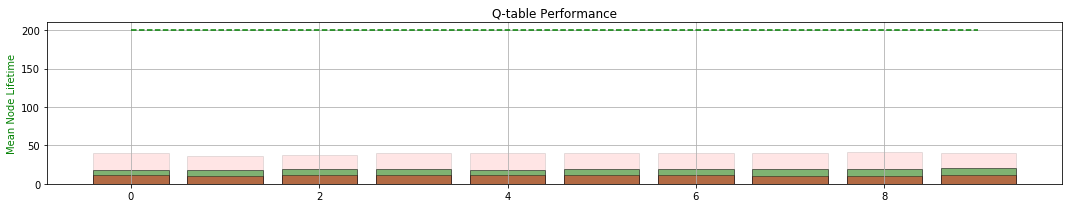

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 882.133	LOSS : 926.163	LOSS : 945.287	LOSS : 940.479	LOSS : 969.464	LOSS : 970.627	LOSS : 894.098	LOSS : 988.455	
Validating... MEAN TIME:  91.65
LOSS : 910.204	LOSS : 946.559	LOSS : 912.015	LOSS : 958.728	LOSS : 892.380	LOSS : 933.008	LOSS : 945.083	LOSS : 977.792	
Validating... MEAN TIME:  91.55
LOSS : 978.388	LOSS : 998.718	LOSS : 952.665	LOSS : 920.904	LOSS : 910.602	LOSS : 965.636	LOSS : 923.567	LOSS : 987.064	
Validating... MEAN TIME:  91.84
LOSS : 940.954	LOSS : 970.069	LOSS : 992.375	LOSS : 955.791	LOSS : 992.843	LOSS : 914.164	LOSS : 996.211	LOSS : 994.313	
Validating... MEAN TIME:  91.68
LOSS : 1041.663	LOSS : 969.757	LOSS : 1012.424	LOSS : 1056.526	LOSS : 994.844	LOSS : 974.434	LOSS : 955.206	LOSS : 960.575	
Validating... MEAN TIME:  91.37
TRAINING TIME:0:00:43.217018


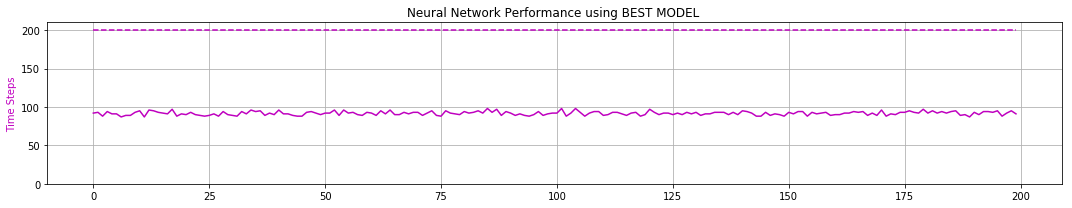

peak memory: 1428.76 MiB, increment: 1053.57 MiB
0 -max- [ 0.220  1.203  0.047  0.376]
0 -min- [-0.178 -1.267 -0.209 -1.678]

1 -max- [ 0.208  1.209  0.051  0.473]
1 -min- [-0.137 -1.154 -0.209 -1.819]

2 -max- [ 0.206  1.137  0.047  0.493]
2 -min- [-0.133 -1.138 -0.209 -1.675]

3 -max- [ 0.207  1.216  0.051  0.370]
3 -min- [-0.162 -1.107 -0.209 -1.677]

4 -max- [ 0.182  1.205  0.050  0.570]
4 -min- [-0.127 -1.238 -0.209 -1.805]

5 -max- [ 0.197  1.209  0.050  0.782]
5 -min- [-0.182 -1.286 -0.209 -1.776]

6 -max- [ 0.202  1.218  0.049  0.377]
6 -min- [-0.131 -1.246 -0.209 -1.691]

7 -max- [ 0.215  1.218  0.050  0.375]
7 -min- [-0.144 -1.141 -0.209 -1.766]

8 -max- [ 0.200  1.173  0.050  0.570]
8 -min- [-0.142 -1.266 -0.209 -1.670]

9 -max- [ 0.224  1.207  0.051  0.375]
9 -min- [-0.162 -1.143 -0.209 -1.787]

Quantization TIME:  0.01 minutes


ITERATION # 47
TOTAL EXPERIENCE GENERATED:   24425
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 91
TOTAL SERIAL TIMESTEPS:   2304412
TOTAL PARALLEL TI

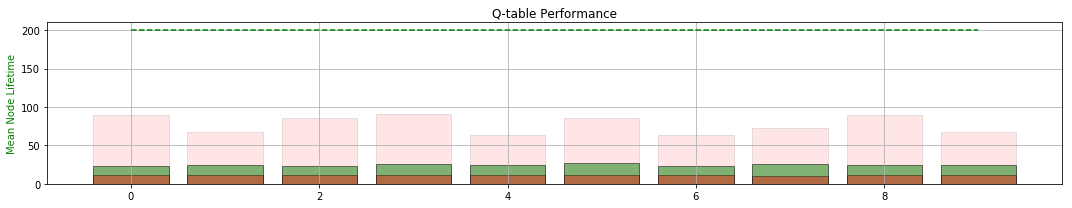

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 983.645	LOSS : 973.445	LOSS : 945.994	LOSS : 986.924	LOSS : 969.441	LOSS : 950.220	LOSS : 924.742	LOSS : 971.582	
Validating... MEAN TIME:  91.43
LOSS : 920.789	LOSS : 935.316	LOSS : 945.337	LOSS : 1000.901	LOSS : 960.674	LOSS : 988.856	LOSS : 923.674	LOSS : 992.207	
Validating... MEAN TIME:  91.565
LOSS : 920.636	LOSS : 985.235	LOSS : 958.654	LOSS : 946.634	LOSS : 962.629	LOSS : 963.452	LOSS : 987.990	LOSS : 1011.539	
Validating... MEAN TIME:  91.88
LOSS : 1021.284	LOSS : 956.194	LOSS : 984.891	LOSS : 969.785	LOSS : 981.168	LOSS : 1008.884	LOSS : 997.423	LOSS : 1039.980	
Validating... MEAN TIME:  91.88
LOSS : 1007.623	LOSS : 972.786	LOSS : 970.824	LOSS : 1022.759	LOSS : 1029.040	LOSS : 983.583	LOSS : 966.265	LOSS : 943.574	
Validating... MEAN TIME:  91.9
TRAINING TIME:0:00:41.333487


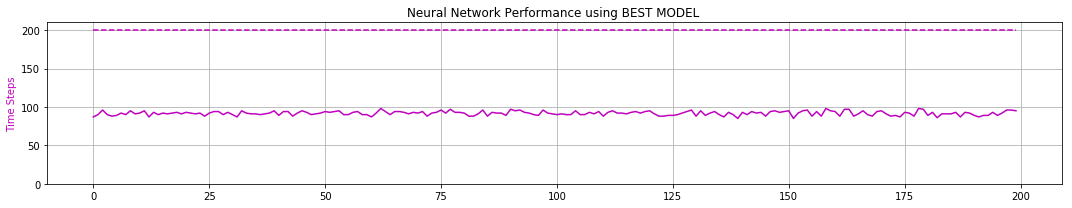

peak memory: 1411.21 MiB, increment: 977.31 MiB
0 -max- [ 0.208  1.216  0.051  0.485]
0 -min- [-2.396 -3.321 -0.209 -1.731]

1 -max- [ 0.205  1.137  0.047  0.562]
1 -min- [-1.145 -2.384 -0.209 -1.675]

2 -max- [ 0.200  1.217  0.050  0.563]
2 -min- [-2.398 -3.338 -0.209 -1.677]

3 -max- [ 0.182  1.200  0.050  0.573]
3 -min- [-2.379 -3.307 -0.209 -1.679]

4 -max- [ 0.194  1.209  0.050  0.503]
4 -min- [-1.016 -2.193 -0.209 -1.727]

5 -max- [ 0.210  1.200  0.049  0.496]
5 -min- [-2.335 -3.328 -0.209 -1.734]

6 -max- [ 0.224  1.218  0.054  0.504]
6 -min- [-1.161 -2.366 -0.209 -1.814]

7 -max- [ 0.200  1.219  0.050  0.377]
7 -min- [-1.320 -2.527 -0.209 -1.802]

8 -max- [ 0.222  1.207  0.051  0.376]
8 -min- [-2.358 -3.323 -0.209 -1.664]

9 -max- [ 0.200  1.179  0.049  0.608]
9 -min- [-1.217 -2.374 -0.209 -1.690]

Quantization TIME:  0.02 minutes


ITERATION # 48
TOTAL EXPERIENCE GENERATED:   24820
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 89
TOTAL SERIAL TIMESTEPS:   2329232
TOTAL PARALLEL TIM

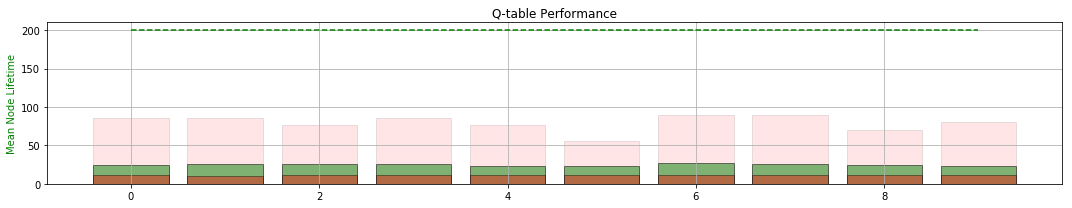

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 994.025	LOSS : 1036.737	LOSS : 957.488	LOSS : 1003.023	LOSS : 977.391	LOSS : 1018.839	LOSS : 962.684	LOSS : 1018.872	
Validating... MEAN TIME:  91.385
LOSS : 1043.059	LOSS : 1014.755	LOSS : 1039.806	LOSS : 1065.603	LOSS : 1014.127	LOSS : 983.765	LOSS : 998.171	LOSS : 1001.829	
Validating... MEAN TIME:  91.65
LOSS : 935.500	LOSS : 939.573	LOSS : 961.900	LOSS : 963.288	LOSS : 952.769	LOSS : 897.664	LOSS : 879.734	LOSS : 909.967	
Validating... MEAN TIME:  91.7
LOSS : 911.553	LOSS : 999.223	LOSS : 941.724	LOSS : 977.866	LOSS : 945.445	LOSS : 975.337	LOSS : 862.638	LOSS : 904.102	
Validating... MEAN TIME:  91.855
LOSS : 910.852	LOSS : 922.488	LOSS : 896.586	LOSS : 909.795	LOSS : 917.177	LOSS : 913.375	LOSS : 925.842	LOSS : 918.066	
Validating... MEAN TIME:  91.595
TRAINING TIME:0:00:41.720654


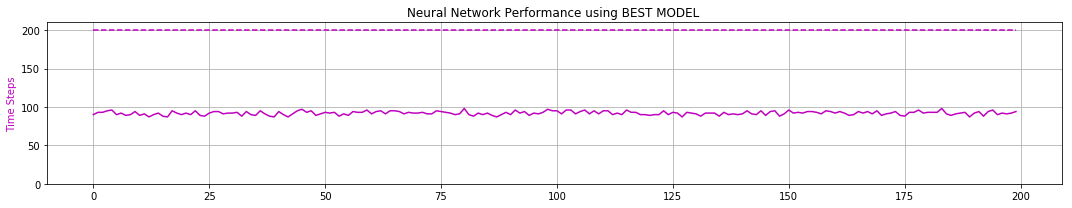

peak memory: 1429.34 MiB, increment: 1019.14 MiB
0 -max- [ 0.199  1.203  0.047  0.435]
0 -min- [-2.373 -3.267 -0.209 -1.755]

1 -max- [ 0.200  1.217  0.050  0.604]
1 -min- [-2.339 -3.338 -0.209 -1.775]

2 -max- [ 0.182  1.200  0.050  0.572]
2 -min- [-1.665 -2.759 -0.209 -1.679]

3 -max- [ 0.192  1.209  0.050  0.540]
3 -min- [-2.346 -3.286 -0.209 -1.776]

4 -max- [ 0.202  1.218  0.049  0.508]
4 -min- [-1.880 -2.913 -0.209 -1.691]

5 -max- [ 0.215  1.218  0.050  0.584]
5 -min- [-0.734 -1.847 -0.209 -1.741]

6 -max- [ 0.200  1.173  0.050  0.543]
6 -min- [-2.392 -3.294 -0.209 -1.770]

7 -max- [ 0.222  1.216  0.051  0.549]
7 -min- [-2.386 -3.323 -0.209 -1.779]

8 -max- [ 0.200  1.179  0.049  0.526]
8 -min- [-1.487 -2.570 -0.209 -1.690]

9 -max- [ 0.196  1.190  0.050  0.592]
9 -min- [-1.801 -2.936 -0.209 -1.833]

Quantization TIME:  0.01 minutes


ITERATION # 49
TOTAL EXPERIENCE GENERATED:   25163
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 93
TOTAL SERIAL TIMESTEPS:   2354395
TOTAL PARALLEL TIM

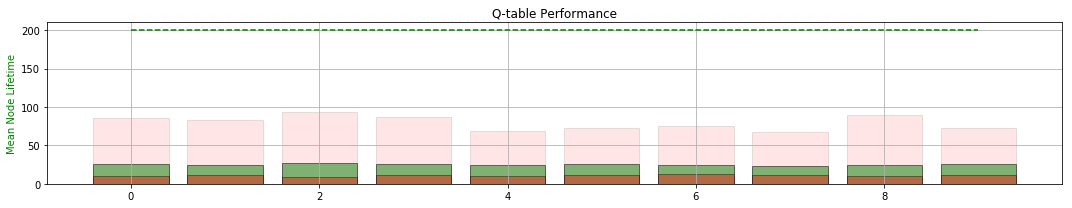

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.0005
LOSS : 923.028	LOSS : 934.680	LOSS : 876.364	LOSS : 924.324	LOSS : 954.594	LOSS : 995.776	LOSS : 944.722	LOSS : 876.036	
Validating... MEAN TIME:  91.84
LOSS : 892.631	LOSS : 856.025	LOSS : 947.292	LOSS : 960.324	LOSS : 898.129	LOSS : 950.185	LOSS : 967.761	LOSS : 956.494	
Validating... MEAN TIME:  91.145
LOSS : 951.278	LOSS : 917.230	LOSS : 879.563	LOSS : 869.532	LOSS : 941.252	LOSS : 887.885	LOSS : 937.723	LOSS : 961.886	
Validating... MEAN TIME:  91.835
LOSS : 946.397	LOSS : 923.963	LOSS : 955.478	LOSS : 913.544	LOSS : 942.467	LOSS : 949.847	LOSS : 891.564	LOSS : 968.610	
Validating... MEAN TIME:  91.96
LOSS : 970.386	LOSS : 911.550	LOSS : 977.275	LOSS : 922.539	LOSS : 904.367	LOSS : 944.974	LOSS : 921.265	LOSS : 961.454	
Validating... MEAN TIME:  92.04
TRAINING TIME:0:00:42.160429


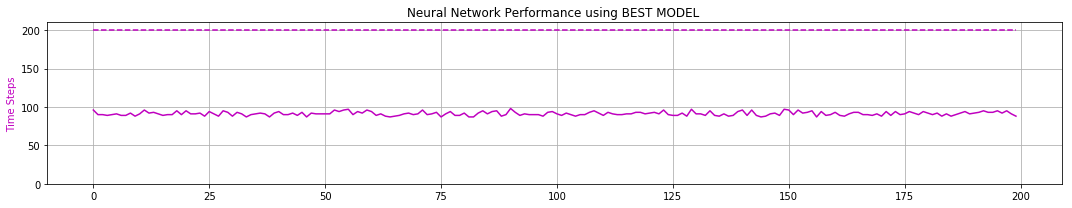

peak memory: 1429.34 MiB, increment: 977.06 MiB
0 -max- [ 0.205  1.219  0.050  0.510]
0 -min- [-2.398 -3.338 -0.209 -1.775]

1 -max- [ 0.182  1.200  0.050  0.598]
1 -min- [-1.902 -2.945 -0.209 -1.679]

2 -max- [ 0.193  1.219  0.050  0.571]
2 -min- [-2.397 -3.432 -0.209 -1.985]

3 -max- [ 0.209  1.218  0.049  0.677]
3 -min- [-2.129 -3.132 -0.209 -1.691]

4 -max- [ 0.215  1.213  0.050  0.600]
4 -min- [-1.292 -2.421 -0.209 -1.814]

5 -max- [ 0.200  1.175  0.050  0.470]
5 -min- [-1.320 -2.527 -0.209 -1.689]

6 -max- [ 0.231  1.208  0.051  0.376]
6 -min- [-1.587 -2.720 -0.209 -1.745]

7 -max- [ 0.200  1.179  0.049  0.577]
7 -min- [-1.217 -2.374 -0.209 -1.690]

8 -max- [ 0.199  1.376  0.050  0.592]
8 -min- [-2.379 -3.296 -0.209 -2.094]

9 -max- [ 0.213  1.200  0.050  0.375]
9 -min- [-1.411 -2.592 -0.209 -1.765]

Quantization TIME:  0.02 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  4777.0
Total Serial Timesteps   :  2354395.0
Speed-up                 :  492.86


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 FAILURE   9  50    4777    2354395     492.86
